# Second Report: Financial Market Volatility

By: Abigail Alpert and Gabi Wurgaft

# Executive Summary
We will be predicting the short term volatility of three stocks. Through these predictions we will make recommendations to their investors and the general public whether to buy, sell, or short this stock. Our predictions will also assess whether the stock is generally stable or very volatile, which will impact decisions of whether to invest in these stocks in the short term.\
Our financial market volatility forecaster provides business value primarily to individuals. Our goal is to create a model that can inform people on whether they should or should not invest in a particular stock for short-term gain. By modelling stock volatility, investors will be more informed about the likelihood of how a specific stock will gain and lose value over a short-term timeframe. This information will (hopefully) help minimize risk.\
The data asset we are using is the AlphaVantage API [1]. It provides 20+ years of historical global equity data in the form of intraday, daily, weekly, and monthly stock prices. We are using 1-minute intraday stock price data for Apple, NextEra Energy, and Eli Lilly. We use this data to calculate the volatility for each day and predict future volatility.

In [62]:
# Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import patchworklib as pw
import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from pmdarima.arima import auto_arima
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf

# Data Preprocessing

We pulled 1-minute intraday stock prices for the three stocks from January 2020 to September 2025. We looked at the summary statistics to better understand the data, as well as plotted the open, close, high, and low prices of each stock to understand any trends. Below are those visualizations and summary statistics:

In [6]:
# Read Data
aapl_df = pd.read_csv("data_files/AAPL_combined.csv.gz")
lly_df = pd.read_csv("data_files/LLY_combined.csv.gz")
nee_df = pd.read_csv("data_files/NEE_combined.csv.gz")

# Data Preprocessing
def data_preprocess(df):
    # Rename columns
    df.rename(columns={'Unnamed: 0': 'timestamp',
                       '1. open': 'open',
                       '2. high': 'high',
                       '3. low': 'low',
                       '4. close': 'close',
                       '5. volume': 'volume'}, inplace=True)
    
    # Drop unnecessary columns
    if 'Unnamed: 0.1' in df.columns.tolist():
        df.drop(columns=['Unnamed: 0.1'], inplace=True)

    # Handle data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp')

    return df

aapl_df = data_preprocess(aapl_df)
lly_df = data_preprocess(lly_df)
nee_df = data_preprocess(nee_df)

For the Apple summary statistics, notice that the stock price varies by about $200 over the full dataframe. Since our data is on a minute level, the values do not differ too much between the open, high, low, and close prices.

In [11]:
aapl_df.describe().drop("timestamp", axis=1)

,open,high,low,close,volume
count,562931.000000,562931.000000,562931.000000,562931.000000,5.629310e+05
mean,160.361242,160.438384,160.283073,160.361462,1.647944e+05
min,51.489400,51.622500,51.426500,51.479800,6.000000e+00
25%,130.441300,130.505000,130.378900,130.439550,6.793800e+04
50%,160.562600,160.665500,160.469400,160.563600,1.116850e+05
75%,190.760100,190.819500,190.695800,190.760100,1.919780e+05
max,258.758900,265.450000,258.559800,258.778700,2.035834e+07
std,45.580128,45.592284,45.567732,45.580169,2.178602e+05


For the Eli Lilly summary statistics notice that the stock price varies by about $850 over the full dataframe. Since our data is in one-minute intervals, the values do not differ too much between the open, high, low, and close prices

In [13]:
lly_df.describe().drop("timestamp", axis=1)

,open,high,low,close,volume
count,558186.000000,558186.000000,558186.000000,558186.000000,5.581860e+05
mean,432.652026,432.851757,432.449151,432.650519,5.859736e+03
min,109.529700,109.810300,109.483000,109.660700,1.000000e+00
25%,208.603300,208.665500,208.537500,208.585400,1.717000e+03
50%,322.778600,322.924050,322.641400,322.787300,3.252000e+03
75%,732.088050,732.484300,731.625400,732.080675,6.246000e+03
max,963.429500,963.726800,961.903500,963.201500,1.246834e+06
std,263.891321,264.021177,263.758754,263.889520,1.108389e+04


For the NextEra Energy, notice that the stock prices varies by about $47 over the full dataframe. This is considerably less than the other stocks that we are looking at, because the share price of NEE is less than AAPL or LLY. Since our data is in one-minute intervals, the values do not differ too much between the open, high, low, and close prices

In [14]:
nee_df.describe().drop("timestamp", axis=1)

,open,high,low,close,volume
count,561062.000000,561062.000000,561062.000000,561062.000000,5.610620e+05
mean,67.876020,67.905372,67.846640,67.876073,1.717475e+04
min,38.178500,38.263500,38.141300,38.212300,1.000000e+00
25%,63.505200,63.533300,63.477200,63.506200,5.937000e+03
50%,69.150500,69.180500,69.122300,69.150500,1.013200e+04
75%,73.489500,73.515800,73.462400,73.489400,1.791600e+04
max,84.675400,85.519400,84.648300,84.675400,4.796161e+06
std,8.168315,8.166782,8.169904,8.168361,3.573411e+04


### Apple Plots

Although there is a general upwards trend over time, the increase in stock price is not consistent

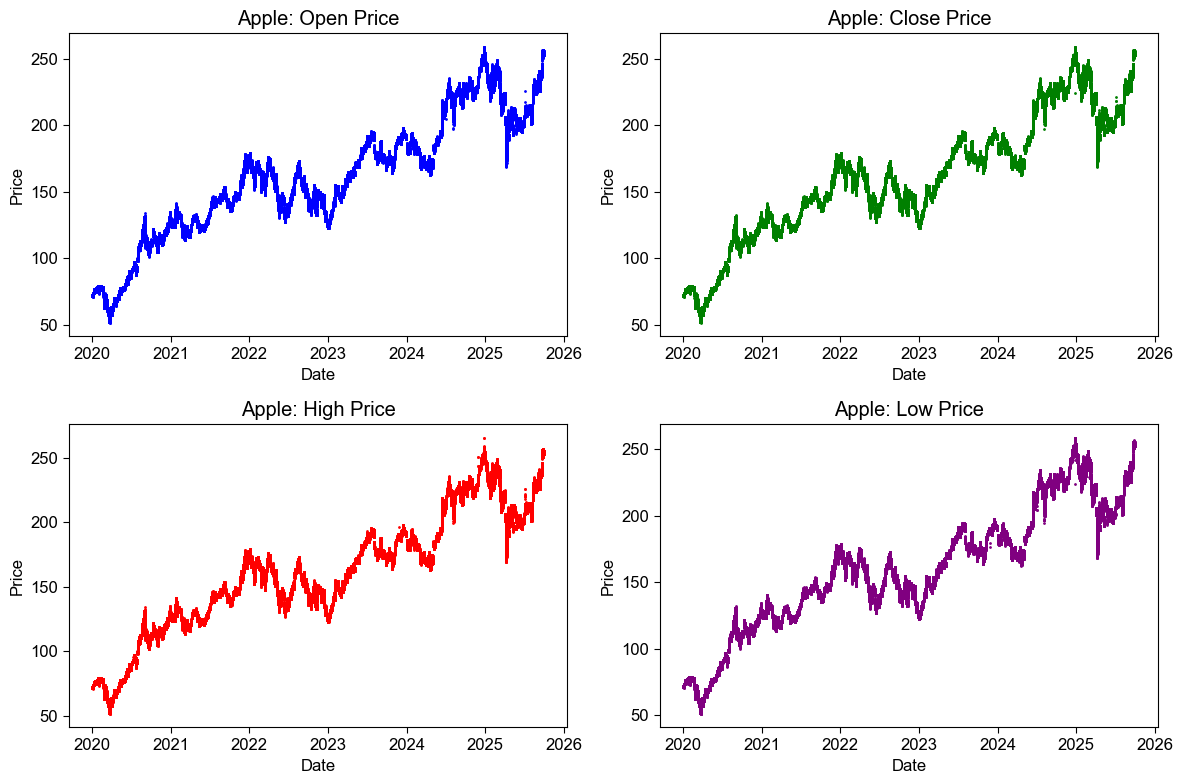

In [15]:
aapl_df['timestamp'] = pd.to_datetime(aapl_df['timestamp'])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

columns = ['open', 'close', 'high', 'low']
titles = ["Apple: Open Price", "Apple: Close Price", "Apple: High Price", "Apple: Low Price"]
colors = ['blue', 'green', 'red', 'purple']

for ax, col, title, color in zip(axs.flat, columns, titles, colors):
    ax.scatter(aapl_df['timestamp'], aapl_df[col], s=1, color=color)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()

### Eli Lilly Plots

Notice that the stock price was increasing steadily until March 2023 when the price increased dramatically. Since June 2024, the LLY stock price has been on a general decreasing trend

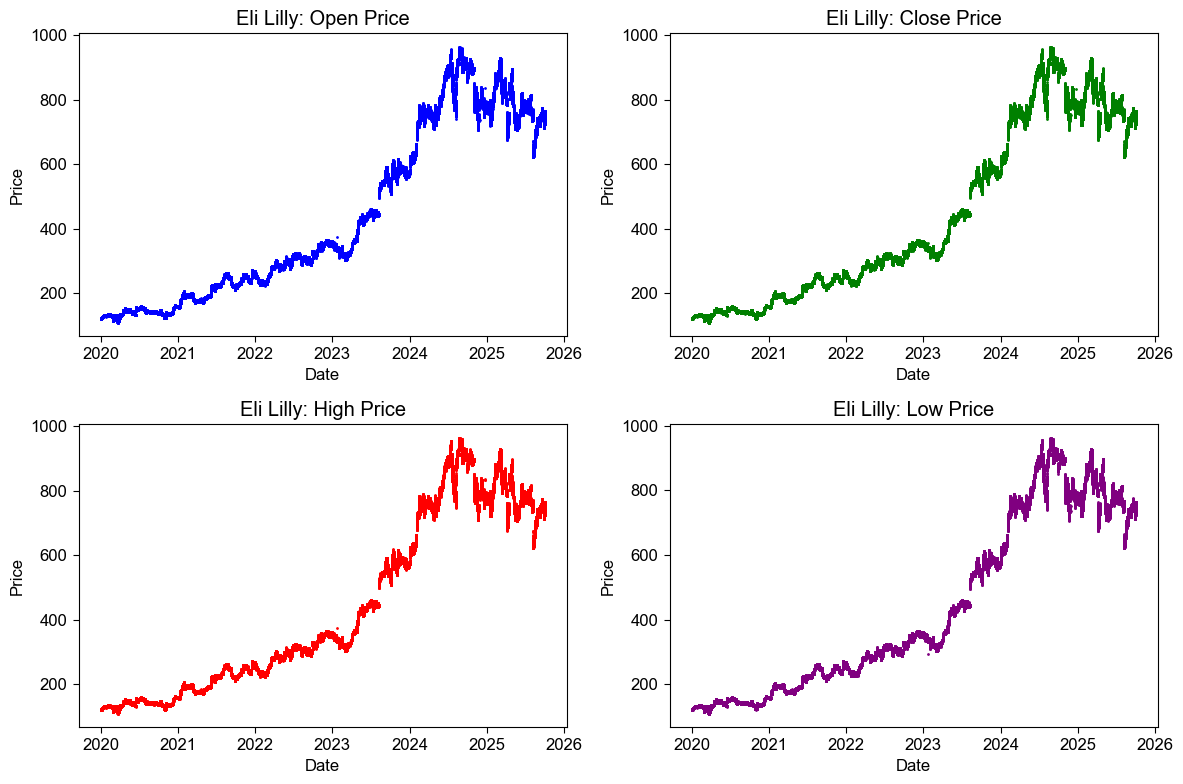

In [18]:

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

columns = ['open', 'close', 'high', 'low']
titles = ["Eli Lilly: Open Price", "Eli Lilly: Close Price", "Eli Lilly: High Price", "Eli Lilly: Low Price"]
colors = ['blue', 'green', 'red', 'purple']

for ax, col, title, color in zip(axs.flat, columns, titles, colors):
    ax.scatter(lly_df['timestamp'], lly_df[col], s=1, color=color)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()

### NextEra Plots

Notice that the NextEra stock price shot up dramatically startin in March 2020 through the end of the year. Since then, there have been many flucations, but a general decrease in stock price. Since the start of 2025, the nee stock prices has been mostly increasing.

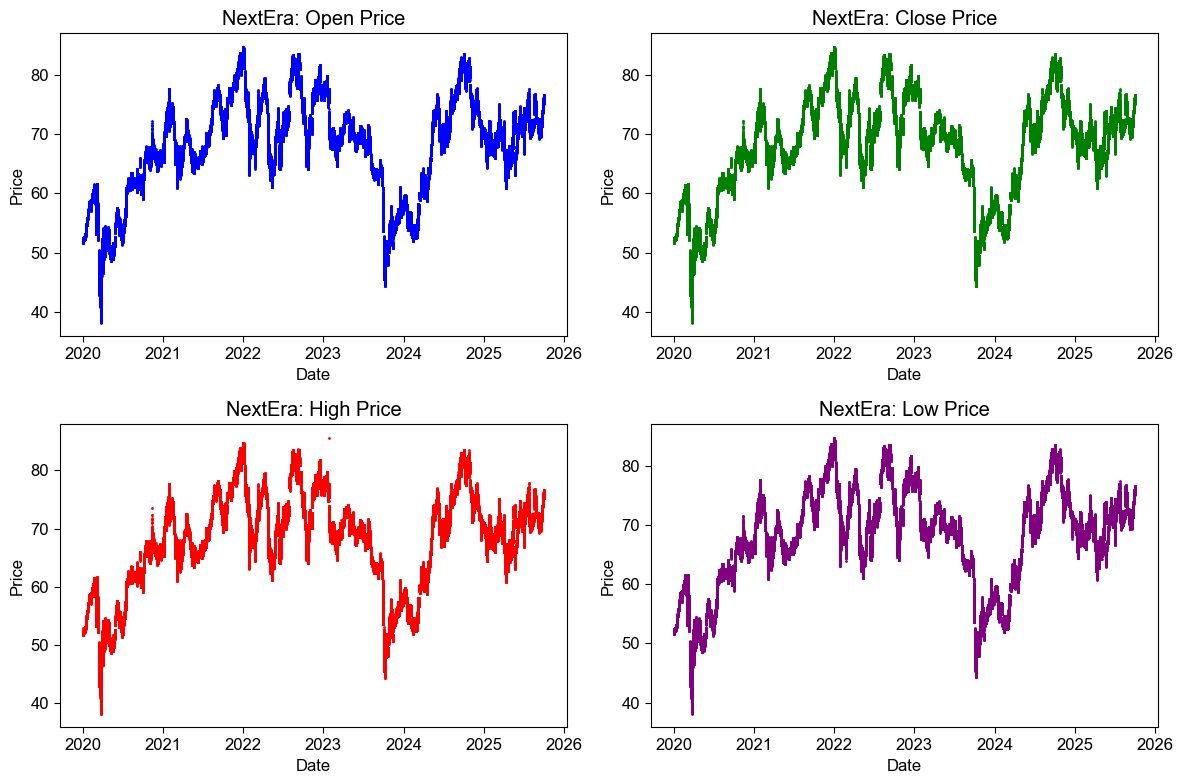

In [17]:

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

columns = ['open', 'close', 'high', 'low']
titles = ["NextEra: Open Price", "NextEra: Close Price", "NextEra: High Price", "NextEra: Low Price"]
colors = ['blue', 'green', 'red', 'purple']

for ax, col, title, color in zip(axs.flat, columns, titles, colors):
    ax.scatter(nee_df['timestamp'], nee_df[col], s=1, color=color)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")

plt.tight_layout()
plt.show()

We then calculated the log returns for each minute using the formula log_returns = log(1+(close-open)/open).

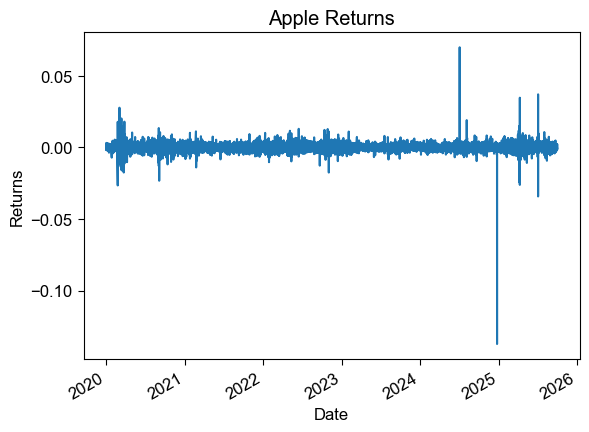

In [19]:
#Load in AAPL data, make returns, variance, and volatility
AAPL_returns = pd.DataFrame({
    "time_stamp": aapl_df['timestamp'],
    "log_return": np.log(1+(aapl_df['close']-aapl_df['open'])/aapl_df['open'])
})
AAPL_returns['time_stamp'] = pd.to_datetime(AAPL_returns['time_stamp'], errors='coerce')
daily_variance_AAPL = AAPL_returns.groupby(AAPL_returns['time_stamp'].dt.floor("1D"))["log_return"].var()
#Plot returns
AAPL_returns.set_index("time_stamp", inplace=True)
AAPL_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Apple Returns")
plt.show()

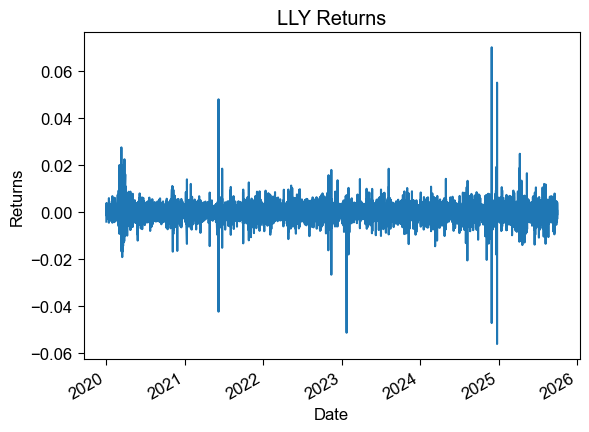

In [20]:
LLY_returns = pd.DataFrame({
    "time_stamp": lly_df["timestamp"],
    "log_return": np.log(1+(lly_df['close']-lly_df['open'])/lly_df['open'])
})
LLY_returns['time_stamp'] = pd.to_datetime(LLY_returns['time_stamp'], errors='coerce')
daily_variance_LLY = LLY_returns.groupby(LLY_returns['time_stamp'].dt.floor("1D"))["log_return"].var()

LLY_returns.set_index("time_stamp", inplace=True)
LLY_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("LLY Returns")
plt.show()

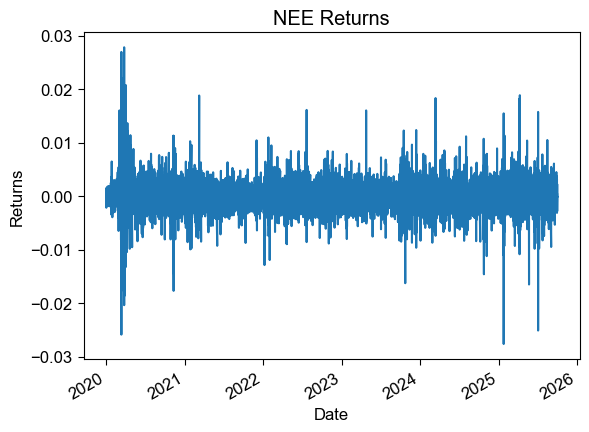

In [21]:
NEE_returns = pd.DataFrame({
    "time_stamp": nee_df["timestamp"],
    "log_return": np.log(1+(nee_df['close']-nee_df['open'])/nee_df['open'])
})
NEE_returns['time_stamp'] = pd.to_datetime(NEE_returns['time_stamp'], errors='coerce')
daily_variance_NEE = NEE_returns.groupby(NEE_returns['time_stamp'].dt.floor("1D"))["log_return"].var()
NEE_returns.set_index("time_stamp", inplace=True)
NEE_returns.log_return.plot()
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("NEE Returns")
plt.show()

From the log return values, we calculated the daily variance of the returns for each of the stocks and took the square root of the variance to calculate the realized volatility for each stock.\
It was important to derive the daily volatility for each stock because we are trying to predict the volatility for the next day. The data needed to be in the form of daily volatility in order to be interpreted and parsed by the different algorithms.

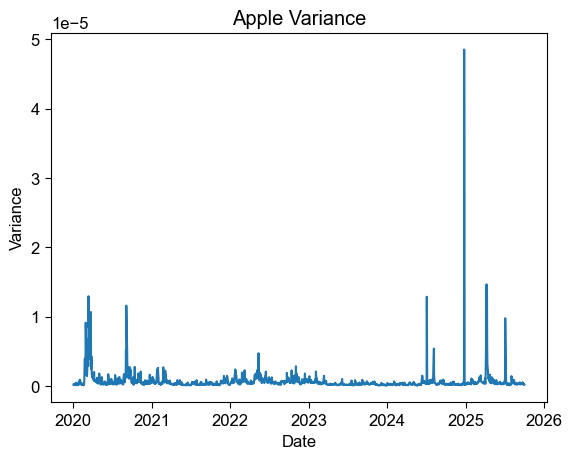

In [22]:
#Plot variance
plt.plot(daily_variance_AAPL.index, daily_variance_AAPL.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("Apple Variance")
plt.show()

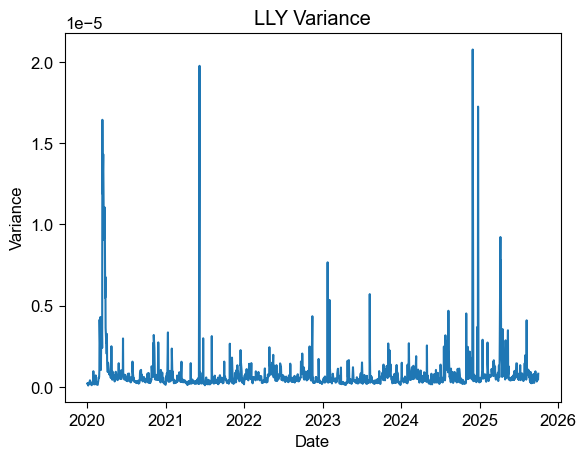

In [23]:
plt.plot(daily_variance_LLY.index, daily_variance_LLY.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("LLY Variance")
plt.show()

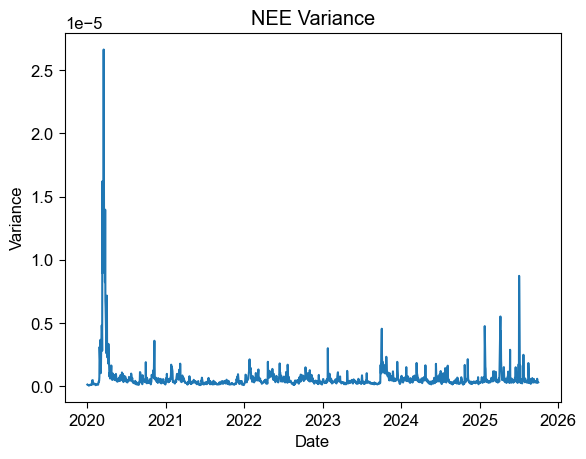

In [24]:
plt.plot(daily_variance_NEE.index, daily_variance_NEE.values)
plt.xlabel("Date")
plt.ylabel("Variance")
plt.title("NEE Variance")
plt.show()

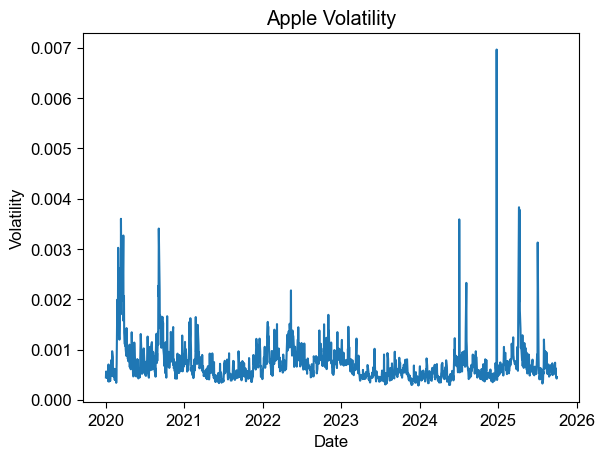

In [25]:
#Plot volatility
daily_volatility_AAPL = np.sqrt(daily_variance_AAPL)
df = pd.DataFrame(daily_volatility_AAPL)
df = df.rename(columns={'log_return': 'volatility'})

plt.plot(daily_volatility_AAPL.index, daily_volatility_AAPL.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Apple Volatility")
plt.show()

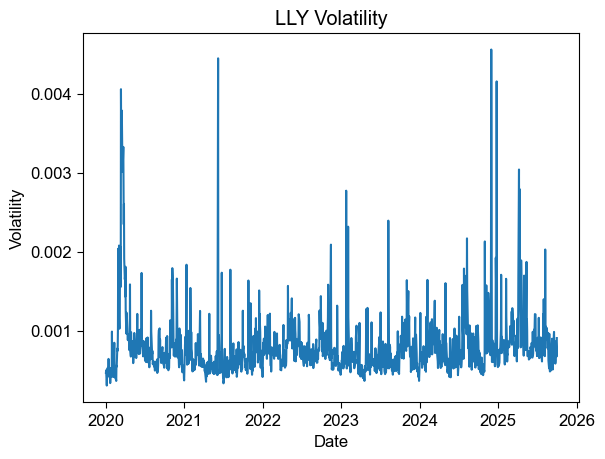

In [26]:
daily_volatility_LLY = np.sqrt(daily_variance_LLY)
plt.plot(daily_volatility_LLY.index, daily_volatility_LLY.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("LLY Volatility")
plt.show()

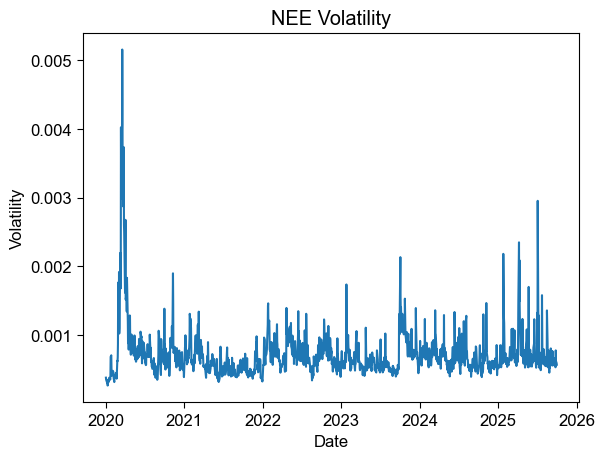

In [27]:
daily_volatility_NEE = np.sqrt(daily_variance_NEE)
plt.plot(daily_volatility_NEE.index, daily_volatility_NEE.values)
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("NEE Volatility")
plt.show()

We also looked at the autocorrelation of the daily volatility for the different stocks to see if it is possible to predict future volatility based on historical data. We found that the current volatility shows a clear dependence on values from roughly two weeks prior. This gave us evidence that we can use historical data to predict future volatility.

### Apple Autocorrelation

1 0.5769819717401945
2 0.5453138915858072
3 0.4821089314745331
4 0.42744278976582956
5 0.38646295829709393


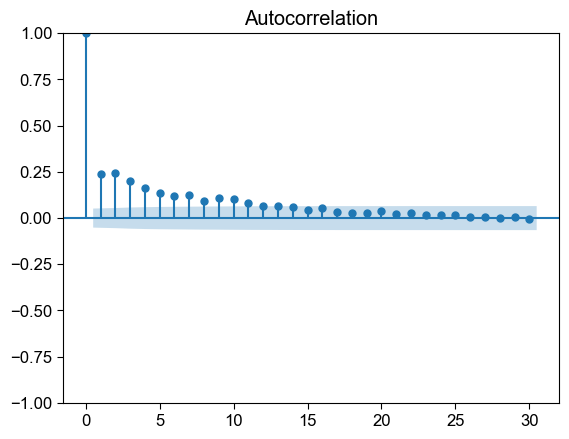

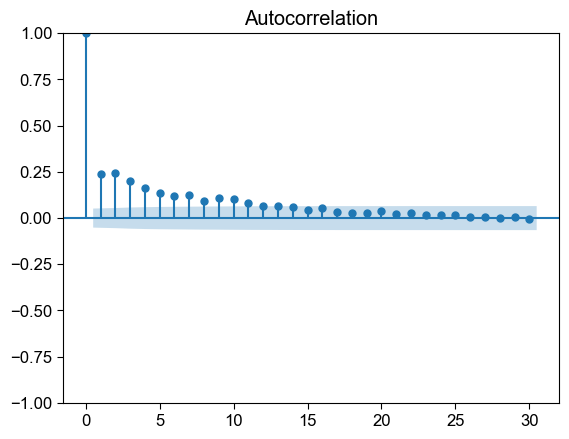

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

for lag in range(1,6):
    print(lag, pd.Series(daily_volatility_AAPL).autocorr(lag=lag))

plot_acf(daily_variance_AAPL, lags=30)

### NextEra Autocorreltation

1 0.8017616162085561
2 0.7593702395381376
3 0.6936932265526221
4 0.6529018873473661
5 0.6014997092740748


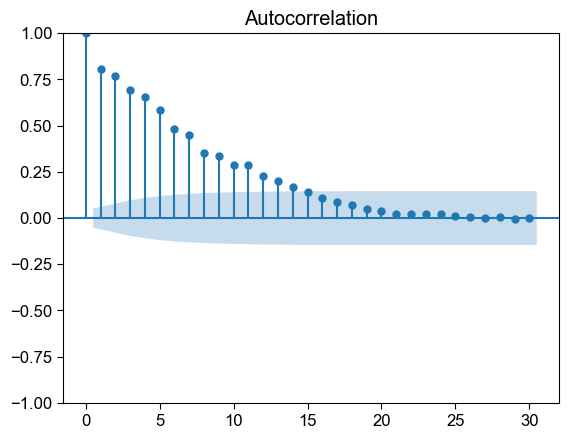

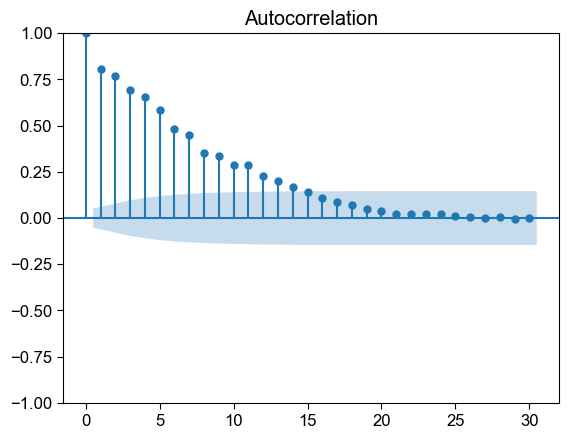

In [29]:
for lag in range(1,6):
    print(lag, pd.Series(daily_volatility_NEE).autocorr(lag=lag))

plot_acf(daily_variance_NEE, lags=30)

### Eli Lilly Autocorrelation

1 0.5470574089843984
2 0.48744457749490466
3 0.42143483172107365
4 0.39808954075840625
5 0.3651819522973271


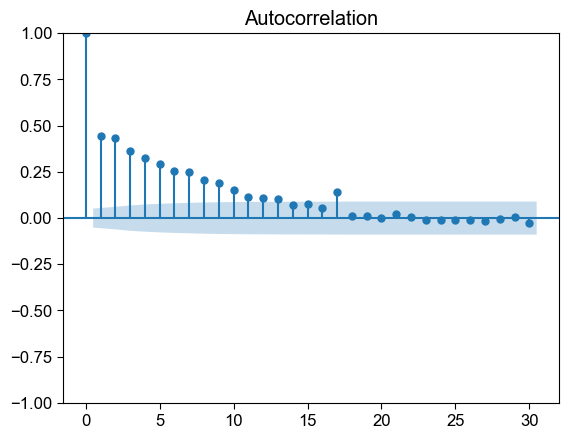

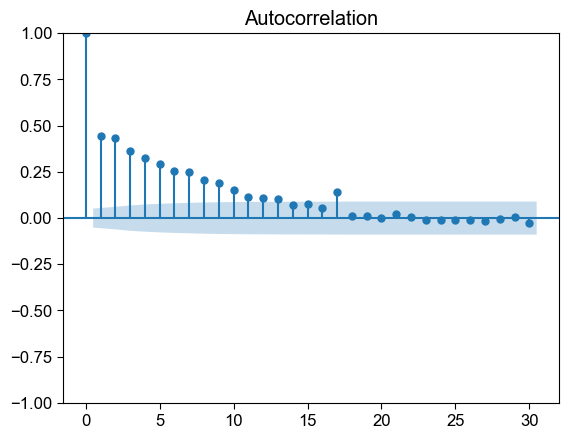

In [30]:
for lag in range(1,6):
    print(lag, pd.Series(daily_volatility_LLY).autocorr(lag=lag))


plot_acf(daily_variance_LLY, lags=30)

To detect outliers, we used the Seasonal Trend Decomposition using LOESS technique that removes the trend and seasonal components from the data so you are left with the residual component. The method to perform this technique is from the python library from statsmodels.tsa.seasonal. Once we had the residual component for each stock, we found the Q1 and Q3 values of the data, the IQR, and filtered the data so that no datapoint is greater than Q3+1.5*IQR or less than Q1+1.5*IRQ.\
However, we ultimately decided to not remove the outliers from the data for building models since we believe that outliers are indicators of volatility. We found that robust models like GARCH and LSTM are able to predict some of what the STL method considers to be outliers.

### Apple Seasonal Trend Decomp.

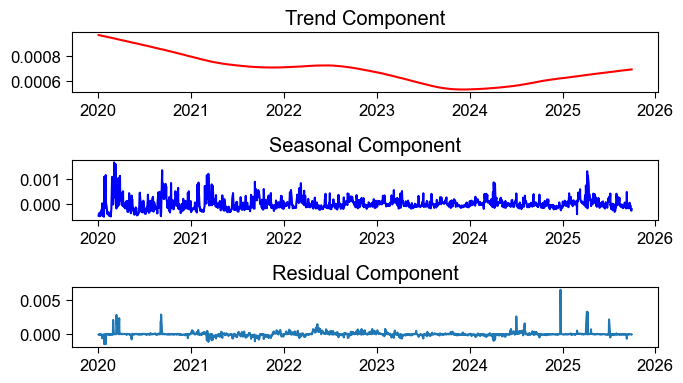

In [84]:
from statsmodels.tsa.seasonal import STL

stl_AAPL = STL(daily_volatility_AAPL.values, period=252, robust=True)
result_AAPL = stl_AAPL.fit()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 4))

#from https://www.geeksforgeeks.org/data-analysis/seasonal-decomposition-of-time-series-by-loess-stl/
ax1.plot(daily_volatility_AAPL.index, result_AAPL.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(daily_volatility_AAPL.index, result_AAPL.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(daily_volatility_AAPL.index, result_AAPL.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()

### NextEra Seasonal Trend Decomp.

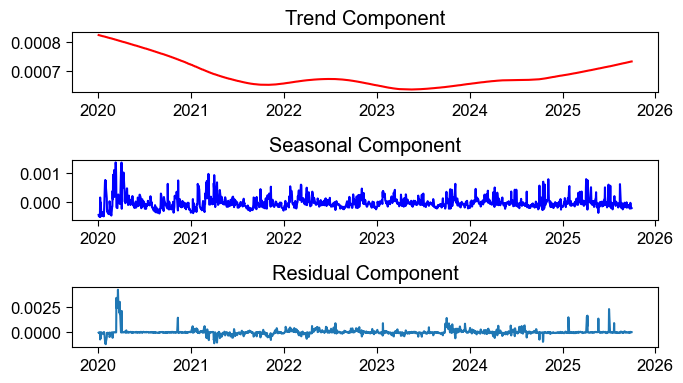

In [85]:
stl_BEP = STL(daily_volatility_NEE.values, period=252, robust=True)
result_BEP = stl_BEP.fit()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 4))

#from https://www.geeksforgeeks.org/data-analysis/seasonal-decomposition-of-time-series-by-loess-stl/
ax1.plot(daily_volatility_NEE.index, result_BEP.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(daily_volatility_NEE.index, result_BEP.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(daily_volatility_NEE.index, result_BEP.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()

### Eli Lilly Seaonsonal Trend Decomp.

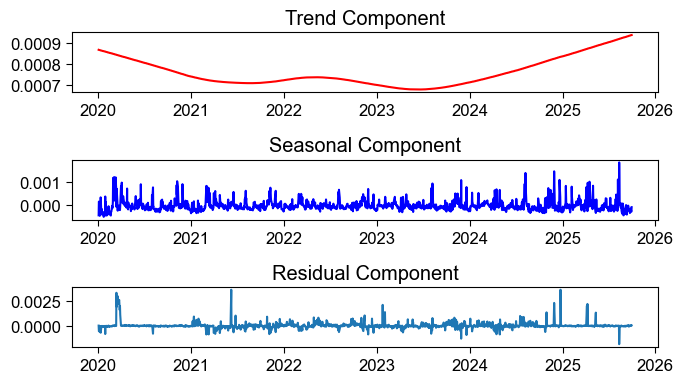

In [86]:
stl_LLY = STL(daily_volatility_LLY.values, period=252, robust=True)
result_LLY = stl_LLY.fit()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 4))

#from https://www.geeksforgeeks.org/data-analysis/seasonal-decomposition-of-time-series-by-loess-stl/
ax1.plot(daily_volatility_LLY.index, result_LLY.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(daily_volatility_LLY.index, result_LLY.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(daily_volatility_LLY.index, result_LLY.resid, label='Residual')
ax3.set_title('Residual Component')
plt.tight_layout()
plt.show()

Additionally, we added supplemental data for the LSTM model. This approach follows from the paper Trading Volume Alpha [2]. We added lagged moving averages of returns, dollar volume, and volatility for each stock over 1, 5, 22, and 44 days. We also added important calendar days in the stock market. These important calendar days were the Federal Open Market Committee meeting days, half days, end of month, MSCI rebalancing days, Option expiry, end of quarter, Russell Index rebalancing day, and triple witching days. This information was retrieved from the NASDAQ calendar datasets. These calendar days were encoded 1-8 with 0 being a non-special calendar day. \
Finally we added a feature that provides information about the quarterly earnings release date. AlphaVantage [1] provides the quarterly earnings reported date. We encoded this feature similar to the Trading Volume Alpha paper [2]. The value zero implies that there is a quarterly release date on that specific day. It encodes the days before or after the release date into categorical bins of [-4,4]. If a date is encoded as 4 this means it is 4 days before the release date, if a date is -2 that means it is two days after the release date. If dates are greater than 5 days before or after any release date, they are encoded as 5. This supplemental data provides more information and gives context to why a stock may perform a certain way on a particular day.\
The methods below were used to encode the features and form the dataset.


In [229]:
stocks = ["AAPL", "LLY", "NEE"]
calendar_codes = {"FOMC": 1, "HalfDays": 2, "MonthEnd": 3, "MSCIrebal": 4, "OptionExpiry": 5, "QuarterEnd": 6, "RusselRebal": 7, "TripleWitch": 8}
daily_metrics = ["DAILY_VOLATILITY", "log_return_MOVING_AVERAGE", "volatility_MOVING_AVERAGE", "volume_MOVING_AVERAGE"]

In [ ]:
MA = ["1", "5", "22", "44"]
for stock in stocks:
    dir_path = f"{path + stock}/"
    df = pd.read_csv(f"{dir_path+stock}_combined.csv.gz")
    
    returns = pd.DataFrame({
    "time_stamp": df['Unnamed: 0'],
    "log_return": np.log(1+(df['4. close']-df['1. open'])/df['1. open']),
    "volume": np.log(df['5. volume'])
    })
    returns['time_stamp'] = pd.to_datetime(returns['time_stamp'], errors='coerce')
    moving_average_types = ['volatility', 'log_return', 'volume']
    for type in moving_average_types:
        if type == "volatility":
            daily_value = returns.groupby(returns['time_stamp'].dt.floor("1D"))["log_return"].std()
            df = pd.DataFrame(daily_value).rename(columns={'log_return': 'volatility'})
            df.to_csv(f"{dir_path + stock}_DAILY_VOLATILITY.csv.gz", compression='gzip')
            
        else:
            daily_value = returns.groupby(returns['time_stamp'].dt.floor("1D"))[type].sum()
            df = pd.DataFrame(daily_value).rename(columns={'log_return': type})
        moving_average_df = pd.DataFrame()
        for window in MA:
            column_name = f'MA_{window}_{type}'
            moving_average_df[column_name] = df[type].shift(1).rolling(window=int(window)).mean()
        moving_average_df.to_csv(f"{dir_path+stock}_{type}_MOVING_AVERAGE.csv.gz", compression='gzip')

In [ ]:
def combine_datasets_by_stock(stock, daily_metrics):
    stock_dataframes = []
    for metric in daily_metrics:
        df = pd.read_csv(f"{path+stock+"/"+ stock}_{metric}.csv.gz")
        stock_dataframes.append(df)
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='time_stamp', how='outer'), stock_dataframes)
    merged_df['time_stamp'] = pd.to_datetime(merged_df['time_stamp'])
    merged_df.insert(loc=0, column='Stock', value=stock)
    return merged_df

In [225]:
def add_cal_dates(calendar_codes, df):
    df["CALENDAR_DAYS"] = 0
    for day in list(calendar_codes.keys()):
        calendar_df = pd.read_csv(f"{path+day}_CALDATES.csv.gz")
        for i in calendar_df['time_stamp']:
            df.loc[df['time_stamp'] == i, "CALENDAR_DAYS"] = calendar_codes[day]
    return df

In [226]:

def earnings_release(df, stock):
    quarterly_earnings_df = pd.read_csv(f'{path+stock+"/"+ stock}_EARNINGS.csv.gz')
    df["QUARTERLY_EARNINGS"] = 5
    encoding_dates_df = pd.DataFrame()
    quarterly_earnings_df['time_stamp'] = pd.to_datetime(quarterly_earnings_df['time_stamp'])
    quarterly_earnings_df = quarterly_earnings_df.sort_values(by='time_stamp', ascending=True)
    for earning_release_date in quarterly_earnings_df['time_stamp']:
        df_backward = pd.DataFrame()
        dates_backward = pd.date_range(end=earning_release_date, periods=6, freq="D")
        df_backward["time_stamp"] = dates_backward
        df_backward["QUARTERLY_EARNINGS"] = (earning_release_date - df_backward["time_stamp"]).dt.days
        df_forward = pd.DataFrame()
        dates_forward = pd.date_range(start=earning_release_date, periods=5, freq="D")
        df_forward["time_stamp"] = dates_forward
        df_forward["QUARTERLY_EARNINGS"] = (earning_release_date - df_forward["time_stamp"]).dt.days
        combined = pd.concat([df_forward, df_backward]).sort_values(by="time_stamp", ascending=True).drop_duplicates()
        encoding_dates_df = pd.concat([encoding_dates_df, combined])
    mapping = dict(zip(encoding_dates_df["time_stamp"], encoding_dates_df["QUARTERLY_EARNINGS"]))
    df.loc[df["time_stamp"].isin(mapping.keys()), "QUARTERLY_EARNINGS"] = df.loc[
        df["time_stamp"].isin(mapping.keys()), "time_stamp"
    ].map(mapping)
    return df

In [ ]:
stock_df = []
for stock in stocks:
    df = combine_datasets_by_stock(stock, daily_metrics)
    df = add_cal_dates(calendar_codes, df)
    df = earnings_release(df, stock)

# Model Updates

We are using four types of models – Exponentially Weighted Moving Average (EWMA), Autoregressive Integrated Moving Average (ARIMA), Generalized Auto-Regressive Conditional Heteroskedasticity (GARCH) and Long Short-Term Memory (LSTM) – to forecast short-term volatility of our selected stocks. We are treating EWMA and ARIMA as our baseline models, since they are both standard statistical models that are easy to interpret. Meanwhile, we hope that our LSTM will form a more robust prediction, despite suffering from the “black-box” phenomenon.

In [31]:
# Data prep
aapl = pd.read_csv("data_files/AAPL_combined.csv.gz")
nee = pd.read_csv("data_files/NEE_combined.csv.gz")
lly = pd.read_csv("data_files/LLY_combined.csv.gz")


def data_preprocess(df):
    # Rename columns
    df.rename(columns={'Unnamed: 0': 'timestamp',
                       '1. open': 'open',
                       '2. high': 'high',
                       '3. low': 'low',
                       '4. close': 'close',
                       '5. volume': 'volume'}, inplace=True)
    
    # Drop unnecessary columns
    if 'Unnamed: 0.1' in df.columns.tolist():
        df.drop(columns=['Unnamed: 0.1'], inplace=True)

    # Handle data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    return df

aapl = data_preprocess(aapl)
nee = data_preprocess(nee)
lly = data_preprocess(lly)

def daily_volatility(df):
    """
    Aggregates to daily level and calculates volatility based on the 
    logic: sqrt(log(1 + (close - open) / open))
    """
    # Select columns and drop NAs
    df = df[['timestamp', 'open', 'close']].dropna().copy()
    
    # Convert timestamp to datetime and extract the date
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    
    # Group by date to get first open and last close
    daily = df.groupby('date').agg(
        open=('open', 'first'),
        close=('close', 'last')
    ).reset_index()
    
    # Calculate log return
    # equivalent to R: log(1 + (close - open) / open) -> log(close / open)
    daily['log_return'] = np.log(1 + (daily['close'] - daily['open']) / daily['open'])
    
    # Calculate volatility
    # Note: If log_return is negative, sqrt will result in NaN. 
    # We use np.sqrt where valid, otherwise NaN.
    daily['volatility'] = daily['log_return'].apply(lambda x: np.sqrt(x) if x > 0 else np.nan)
    
    # Return only date and volatility, dropping any rows where calculation failed (NaNs)
    return daily[['date', 'volatility']].dropna()

aapl_vol = daily_volatility(aapl)
nee_vol = daily_volatility(nee)
lly_vol = daily_volatility(lly)

### EWMA

Exponentially weighted moving average is a classic model used for time series forecasting. The model gives more weight to the more recent data than older data. This is the initial baseline model since it is very simple. EWMA is a variant of a Moving Average model that weighs observations based on their temporal proximity to the prediction time. EWMA models are often used for financial market volatility prediction because heavier weights on more recent observations allow the model to react more quickly to clusters and spikes in the data than a standard Moving Average model can react.

The EWMA model has one parameter called lambda (also called alpha sometimes), which is the decay rate, thus influencing how the weights of historic data are calculated. Originally, after a quick visual check, we thought that an EWMA model with a decay factor of 0.9 best fit our data, as can be seen in the graphs below. Next, we completed a more thorough and data-driven check using a variant of 5-fold cross-validation with time-aware splits. Using RMSE as our metric, we found that the optimal lambda parameter values are as follows:

| Ticker | Lambda |
|--------|---------|
| AAPL   | 0.05    |
| NEE    | 0.01    |
| LLY    | 0.01    |

We evaluated the performance of the model with our testing data looking at RMSE, AIC, and BIC.


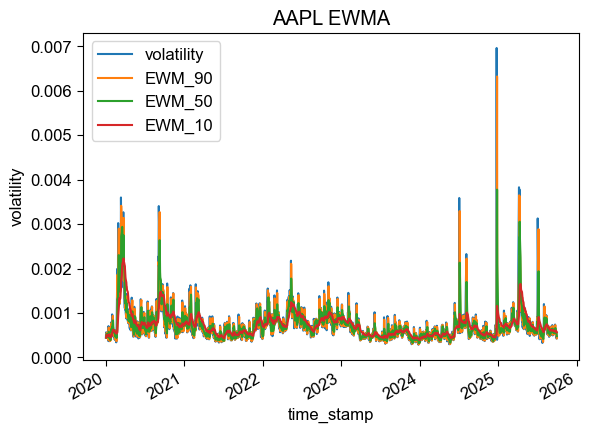

In [32]:
# AAPL EWMA -- Prelim
daily_volatility_AAPL.name = 'volatility'
daily_volatility_AAPL = daily_volatility_AAPL.to_frame()
daily_volatility_AAPL['EWM_90'] = daily_volatility_AAPL['volatility'].shift(1).ewm(alpha=.90).mean()
daily_volatility_AAPL['EWM_50'] = daily_volatility_AAPL['volatility'].shift(1).ewm(alpha=.50).mean()
daily_volatility_AAPL['EWM_10'] = daily_volatility_AAPL['volatility'].shift(1).ewm(alpha=.10).mean()
daily_volatility_AAPL.plot()
plt.title("AAPL EWMA")
plt.ylabel("volatility")
plt.show()

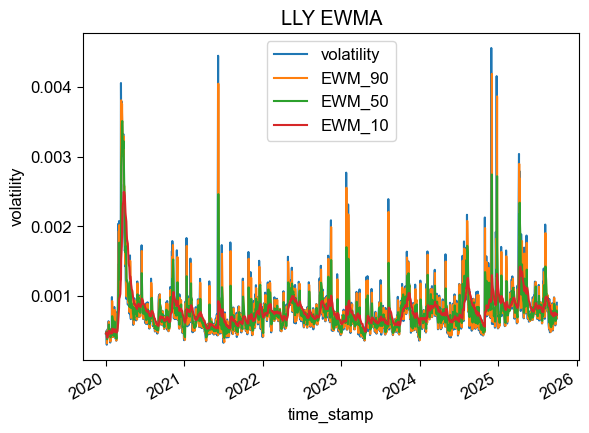

In [33]:
# LLY EWMA -- Prelim
daily_volatility_LLY.name = 'volatility'
daily_volatility_LLY = daily_volatility_LLY.to_frame()
daily_volatility_LLY['EWM_90'] = daily_volatility_LLY['volatility'].shift(1).ewm(alpha=.90).mean()
daily_volatility_LLY['EWM_50'] = daily_volatility_LLY['volatility'].shift(1).ewm(alpha=.50).mean()
daily_volatility_LLY['EWM_10'] = daily_volatility_LLY['volatility'].shift(1).ewm(alpha=.10).mean()
daily_volatility_LLY.plot()
plt.title("LLY EWMA")
plt.ylabel("volatility")
plt.show()

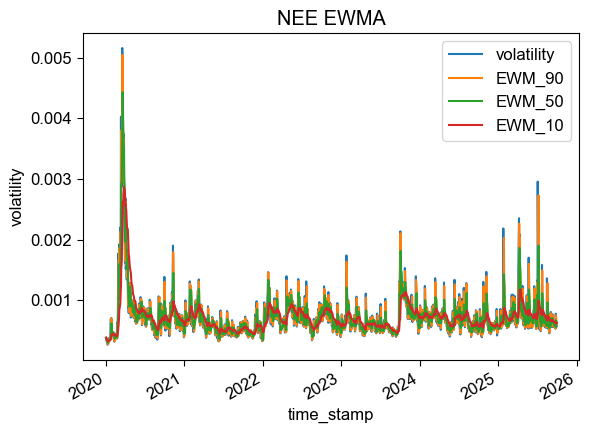

In [34]:
# NEE EWMA -- Prelim
daily_volatility_NEE.name = 'volatility'
daily_volatility_NEE = daily_volatility_NEE.to_frame()
daily_volatility_NEE['EWM_90'] = daily_volatility_NEE['volatility'].shift(1).ewm(alpha=.90).mean()
daily_volatility_NEE['EWM_50'] = daily_volatility_NEE['volatility'].shift(1).ewm(alpha=.50).mean()
daily_volatility_NEE['EWM_10'] = daily_volatility_NEE['volatility'].shift(1).ewm(alpha=.10).mean()
daily_volatility_NEE.plot()
plt.title("NEE EWMA")
plt.ylabel("volatility")
plt.show()

In [35]:
# Robust EWMA implementation
class EWMAResults:

    def __init__(self, data, lambda_val):
        self._data = data
        self._lambda = lambda_val
    
        self.conditional_volatility = data.ewm(alpha=lambda_val, adjust=False).mean()
        self.resid = data - self.conditional_volatility

    def summary(self):
        print("EWMA Model Results")
        print("==================")
        print(f"Lambda (alpha): {self._lambda}")
        print(f"Last Volatility: {self.conditional_volatility.iloc[-1]:.5f}")
        return ""

    def forecast(self, horizon=1):
        last_vol = self.conditional_volatility.iloc[-1]

        class ForecastObj:
            def __init__(self, val, h):
                self.volatility = pd.Series([val] * h, name='h.1')
                self.variance = self.volatility ** 2
        
        return ForecastObj(last_vol, horizon)
    
def fit_ewma(df, lambda_):

    series = df['volatility'] 
    
    results = EWMAResults(series, lambda_)
    
    return results

def find_best_lambda_cv(vol_series, n_splits=5):

    lambdas = np.linspace(0.01, 0.99, 50)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    avg_rmse_scores = []
    
    print(f"--- Hyper-tuning Lambda with {n_splits}-Fold CV ---")
    
    for lam in lambdas:
        fold_rmses = []
        
        for train_index, test_index in tscv.split(vol_series):
            # Split data
            train = vol_series.iloc[train_index]
            test = vol_series.iloc[test_index]

            train_ewma = train.ewm(alpha=lam, adjust=False).mean()
            last_train_vol = train_ewma.iloc[-1]
            
            full_chunk = vol_series.iloc[np.concatenate([train_index, test_index])]
            full_ewma = full_chunk.ewm(alpha=lam, adjust=False).mean()
            
            predictions = full_ewma.shift(1).iloc[test_index]
            
            actuals = test
            
            valid = ~np.isnan(predictions)
            rmse = np.sqrt(mean_squared_error(actuals[valid], predictions[valid]))
            fold_rmses.append(rmse)
        
        avg_rmse_scores.append(np.mean(fold_rmses))

    best_idx = np.argmin(avg_rmse_scores)
    best_lambda = lambdas[best_idx]
    best_score = avg_rmse_scores[best_idx]
    
    return best_lambda

In [36]:
best_lam = find_best_lambda_cv(aapl_vol['volatility'], n_splits=5)
print(f"Optimal Lambda found aapl: {best_lam:.3f}")
best_lam = find_best_lambda_cv(nee_vol['volatility'], n_splits=5)
print(f"Optimal Lambda found nee: {best_lam:.3f}")
best_lam = find_best_lambda_cv(lly_vol['volatility'], n_splits=5)
print(f"Optimal Lambda found lly: {best_lam:.3f}")

--- Hyper-tuning Lambda with 5-Fold CV ---
Optimal Lambda found aapl: 0.050
--- Hyper-tuning Lambda with 5-Fold CV ---
Optimal Lambda found nee: 0.010
--- Hyper-tuning Lambda with 5-Fold CV ---
Optimal Lambda found lly: 0.010


In [96]:
aapl_ewma = fit_ewma(aapl_vol, lambda_ = 0.05)
nee_ewma = fit_ewma(nee_vol, lambda_= 0.01)
lly_ewma = fit_ewma(lly_vol, lambda_ = 0.01)

### ARIMA

ARIMA is a variant of an Autoregressive Moving Average (ARMA) model that allows for analysis and predictions for non-stationary data. The integration (differencing) removes the underlying trends in the data, allowing for the data to be “assumed” as stationary data. Meanwhile, the Autoregressive part of the model captures the dependence on past observation values. The Moving Average portion of the model addresses the past forecast errors, or how much the model depends on past shocks. Like EWMA, ARIMA models are also commonly used for volatility forecasting since volatility series typically exhibit autocorrelation and mean reversion.

ARIMA models typically have three parameters – p, d, and q. The parameter p is the order of the auto-regressive component of the model. The parameter d is the degree of differencing needed to make the data stationary. The parameter q is the order of the moving average component of the model. Traditionally, parameters would need to be tuned using methods like k-fold cross-validation. Since standard K-fold cross-validation does not work for time series data, we used a model that self-optimizes the parameters. We used one of these models, auto_arima from “pmdarima” called “auto_arima.” The parameters are tuned by performing a smart version of grid search over different parameter values. First, the model finds the correct d value, the differencing degree that makes the data stationary, using stationarity tests. Then, with d fixed, the program performs a stepwise search using AIC for evaluation to find the optimal p and q values. This parameter tuning method is fast and statistically sound.

The optimal parameters are as follows:

| Ticker | p | d | q |
|--------|---|---|---|
| AAPL   | 0 | 1 | 1 |
| NEE    | 1 | 0 | 1 |
| LLY    | 1 | 0 | 1 |

We evaluated the performance of the model with our testing data looking at RMSE, AIC, and BIC.


--- Auto ARIMA for AAPL ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  775
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1305.051
Date:                Fri, 12 Dec 2025   AIC                          -2606.102
Time:                        12:34:48   BIC                          -2596.799
Sample:                             0   HQIC                         -2602.523
                                - 775                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9425      0.011    -82.846      0.000      -0.965      -0.920
sigma2         0.0020   7.28e-05     27.529      0.000       0.002       0.002
Ljung-Box (L1) (Q):     

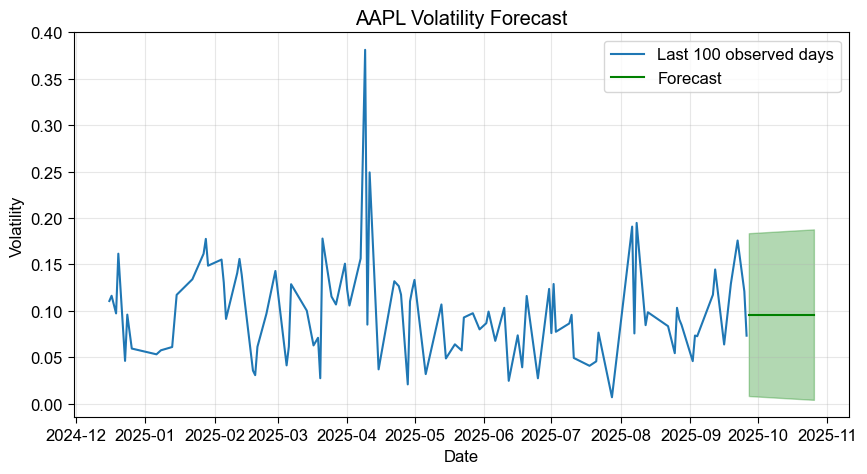

--- Auto ARIMA for NEE ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  746
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1266.845
Date:                Fri, 12 Dec 2025   AIC                          -2525.691
Time:                        12:34:51   BIC                          -2507.232
Sample:                             0   HQIC                         -2518.576
                                - 746                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0099      0.005      1.890      0.059      -0.000       0.020
ar.L1          0.8948      0.055     16.174      0.000       0.786       1.003
ma.L1         -0.8233    

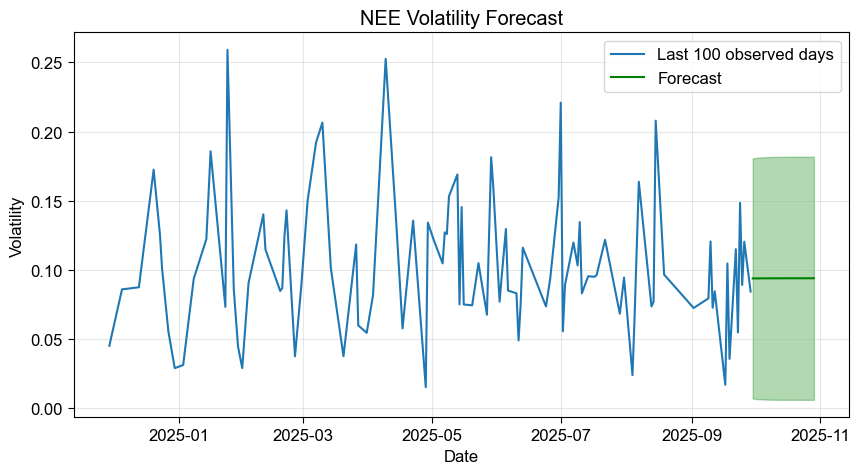

--- Auto ARIMA for LLY ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  756
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1246.578
Date:                Fri, 12 Dec 2025   AIC                          -2485.156
Time:                        12:34:55   BIC                          -2466.644
Sample:                             0   HQIC                         -2478.025
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0129      0.007      1.928      0.054      -0.000       0.026
ar.L1          0.8676      0.068     12.697      0.000       0.734       1.002
ma.L1         -0.7805    

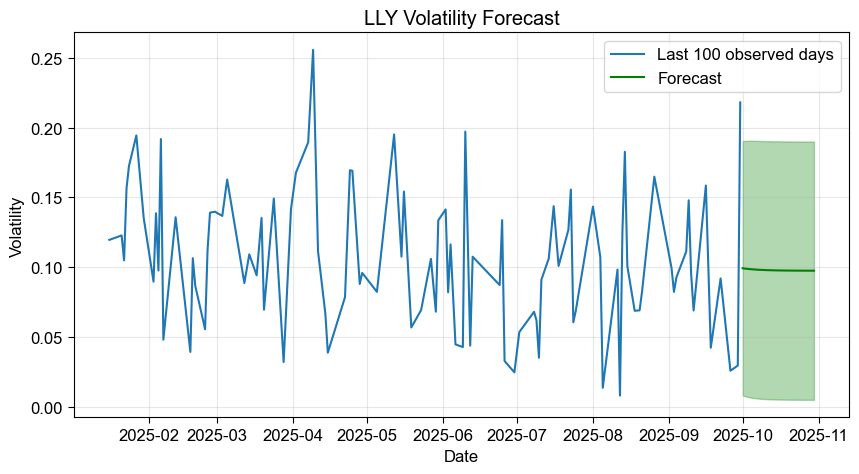

In [97]:
def fit_and_plot_arima(df, name):
    print(f"--- Auto ARIMA for {name} ---")

    # Make data a series
    series = df['volatility'].values
    
    # Model
    model = auto_arima(series, seasonal=False, error_action='ignore', suppress_warnings=True)
    print(model.summary())
    
    # Forecast
    n_periods = 30
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    last_date = df['date'].iloc[-1]
    forecast_dates = [last_date + pd.Timedelta(days=x) for x in range(1, n_periods + 1)]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'][-100:], series[-100:], label='Last 100 observed days') # historic
    plt.plot(forecast_dates, forecast, label='Forecast', color='green') # forecast
    plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='green', alpha=0.3)
    plt.title(f"{name} Volatility Forecast")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


fit_and_plot_arima(aapl_vol, "AAPL")
fit_and_plot_arima(nee_vol, "NEE")
fit_and_plot_arima(lly_vol, "LLY")

In [98]:
def fit_arima(df):

    series = df['volatility'].values

    model = auto_arima(series, seasonal=False, error_action='ignore', suppress_warnings=True)

    return model

aapl_arima = fit_arima(aapl_vol)
nee_arima = fit_arima(nee_vol)
lly_arima = fit_arima(lly_vol)

### GARCH

A GARCH model is an extension of the ARCH framework that allows for modeling and forecasting time-varying volatility in a series. Instead of assuming constant variance, GARCH explicitly models the conditional variance as a function of past shocks and past variances. The auto-regressive part of the model captures how past volatility persists into the present, while the moving-average component reflects how new information, like large shocks, immediately increases volatility. Similar to our other baseline models, GARCH is commonly used for financial market volatility prediction because GARCH models can address volatility clustering, mean reversion, and periods of large and small fluctuations. The standard parameters are GARCH(1, 1).

GARCH models have two parameters – p and q. The p parameter is the GARCH order, which represents the lagged conditional variances and captures the volatility present. Larger p values mean that volatility decays more slowly. The q parameter is the ARCH orde,r which represents the lagged squared variances and captures the information in the shocks. Larger q values mean that the model reacts more strongly to recent shocks. Once again, traditional k-fold CV does not work for parameter tuning because we are using time series data. Instead, we use a combination of grid search and cross-validation that allows us to preserve the time relationships within the data while comparing model performance under different parameters. During this tuning, we use MSE for model comparison since MSE generalizes well.

The optimal parameters are as follows:

| Ticker | p | q |
|--------|---|---|
| AAPL   | 1 | 1 |
| NEE    | 2 | 3 |
| LLY    | 3 | 3 |

We evaluated the performance of the model with our testing data looking at RMSE, AIC, and BIC.


In [99]:
def optimize_garch_cv(returns_series, n_splits=5):
    """
    Finds best p, q using Time Series Cross-Validation.
    Metric: MSE of (Predicted Variance - Actual Squared Returns).
    """
    
    # Grid
    p_range = [1, 2, 3]
    q_range = [1, 2, 3]
    
    # TS data split
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    results = []

    print(f"{'p':<4} {'q':<4} {'Avg MSE':<15}")
    print("-" * 30)

    # Grid search
    for p in p_range:
        for q in q_range:
            mse_scores = []
            
            # CV "Folds"
            for train_idx, test_idx in tscv.split(returns_series):
                # Split data
                train_data = returns_series.iloc[train_idx]
                test_data = returns_series.iloc[test_idx]
                
                # Fit Model
                try:
                    model = arch_model(train_data, vol='Garch', p=p, q=q, mean='Zero')
                    res = model.fit(disp='off')
           
                    forecasts = res.forecast(horizon=len(test_data), reindex=False)
                    
                    pred_variance = forecasts.variance.values[-1]
                    
                    actual_variance_proxy = test_data ** 2
                    
                    mse = mean_squared_error(actual_variance_proxy, pred_variance)
                    mse_scores.append(mse)
                    
                except:
                    continue
            
            # Average score across all folds
            if mse_scores:
                avg_mse = np.mean(mse_scores)
                results.append({'p': p, 'q': q, 'score': avg_mse})
                print(f"{p:<4} {q:<4} {avg_mse:.4f}")

    results_df = pd.DataFrame(results)
    best_params = results_df.loc[results_df['score'].idxmin()]
    
    print("-" * 30)
    print(f"BEST PARAMS via CV: p={int(best_params.p)}, q={int(best_params.q)}")
    return int(best_params.p), int(best_params.q)

In [100]:
print("------ GARCH for AAPL -------")
best_p, best_q = optimize_garch_cv(aapl_vol['volatility'])
aapl_garch = arch_model(aapl_vol['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
aapl_res = aapl_garch.fit(disp='off')
print(aapl_res.summary())

------ GARCH for AAPL -------
p    q    Avg MSE        
------------------------------
1    1    0.0001
1    2    0.0001
1    3    0.0001
2    1    0.0001
2    2    0.0001
2    3    0.0001
3    1    0.0001
3    2    0.0001
3    3    0.0001
------------------------------
BEST PARAMS via CV: p=1, q=1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                633.042
Distribution:                  Normal   AIC:                          -1260.08
Method:            Maximum Likelihood   BIC:                          -1246.13
                                        No. Observations:                  775
Date:                Fri, Dec 12 2025   Df Residuals:                      775
Time:                        12:45:30   Df Model:                   

In [102]:
print("------ GARCH for LLY -------")
best_p, best_q = optimize_garch_cv(lly_vol['volatility'])
lly_garch = arch_model(lly_vol['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
lly_res = lly_garch.fit(disp='off')
print(lly_res.summary())

------ GARCH for LLY -------
p    q    Avg MSE        
------------------------------
1    1    0.0001
1    2    0.0001
1    3    0.0001
2    1    0.0001
2    2    0.0001
2    3    0.0001
3    1    0.0001
3    2    0.0001
3    3    0.0001
------------------------------
BEST PARAMS via CV: p=3, q=3
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                609.995
Distribution:                  Normal   AIC:                          -1205.99
Method:            Maximum Likelihood   BIC:                          -1173.59
                                        No. Observations:                  756
Date:                Fri, Dec 12 2025   Df Residuals:                      756
Time:                        12:45:57   Df Model:                    

In [101]:
print("------ GARCH for NEE -------")
best_p, best_q = optimize_garch_cv(nee_vol['volatility'])
nee_garch = arch_model(nee_vol['volatility'], vol='Garch', p=best_p, q=best_q, mean='Zero')
nee_res = nee_garch.fit(disp='off')
print(nee_res.summary())

------ GARCH for NEE -------
p    q    Avg MSE        
------------------------------
1    1    0.0001
1    2    0.0001
1    3    0.0001
2    1    0.0001
2    2    0.0001
2    3    0.0001
3    1    0.0001
3    2    0.0001
3    3    0.0001
------------------------------
BEST PARAMS via CV: p=2, q=3
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                636.643
Distribution:                  Normal   AIC:                          -1261.29
Method:            Maximum Likelihood   BIC:                          -1233.60
                                        No. Observations:                  746
Date:                Fri, Dec 12 2025   Df Residuals:                      746
Time:                        12:45:44   Df Model:                    


--- Fitting GARCH(1, 1) for AAPL ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                633.042
Distribution:                  Normal   AIC:                          -1260.08
Method:            Maximum Likelihood   BIC:                          -1246.13
                                        No. Observations:                  775
Date:                Fri, Dec 12 2025   Df Residuals:                      775
Time:                        12:47:15   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.4402

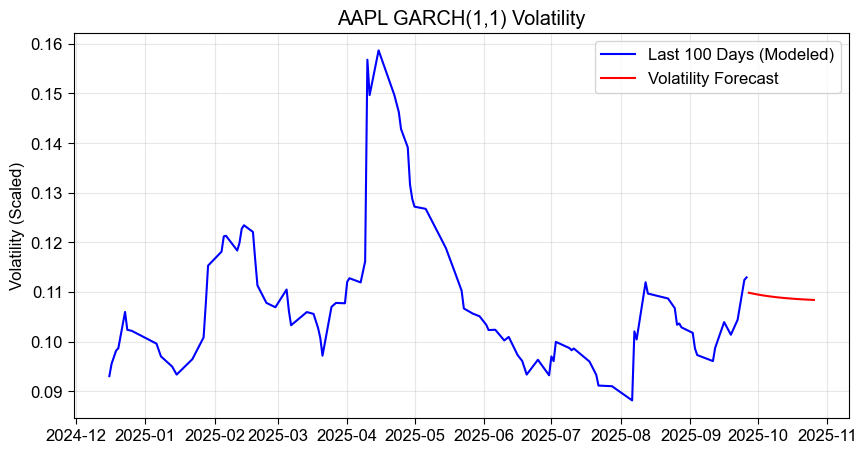


--- Fitting GARCH(2, 3) for NEE ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                636.643
Distribution:                  Normal   AIC:                          -1261.29
Method:            Maximum Likelihood   BIC:                          -1233.60
                                        No. Observations:                  746
Date:                Fri, Dec 12 2025   Df Residuals:                      746
Time:                        12:47:15   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.0950e

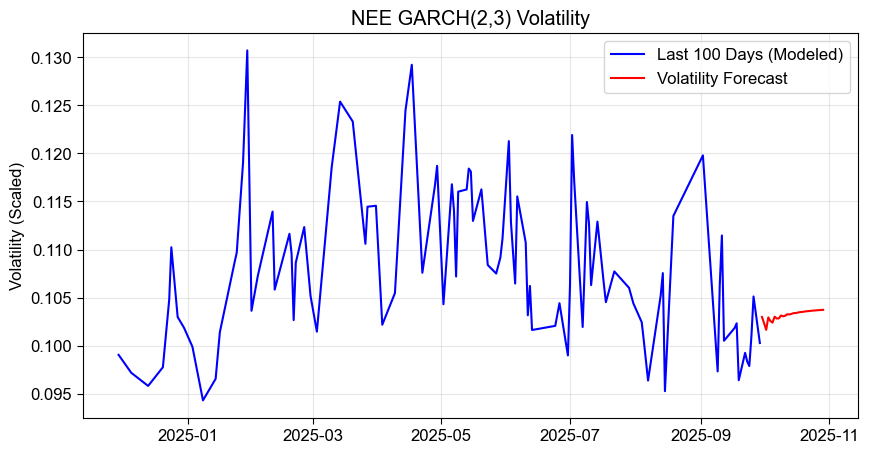


--- Fitting GARCH(3, 3) for LLY ---
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                609.995
Distribution:                  Normal   AIC:                          -1205.99
Method:            Maximum Likelihood   BIC:                          -1173.59
                                        No. Observations:                  756
Date:                Fri, Dec 12 2025   Df Residuals:                      756
Time:                        12:47:16   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.1117e

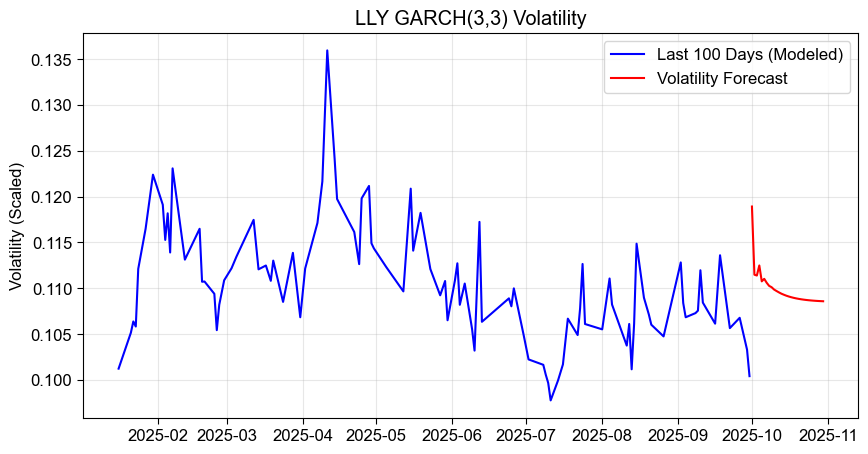

In [103]:
def fit_and_forecast_garch_pq(df, ticker_name, p, q):
    print(f"\n--- Fitting GARCH({p}, {q}) for {ticker_name} ---")
    
    # Model
    model = arch_model(df['volatility'], vol='Garch', p=p, q=q, mean='Zero')
    results = model.fit(disp='off')
    print(results.summary())
    
    # Forecast
    forecast_horizon = 30
    forecasts = results.forecast(horizon=forecast_horizon)
    pred_variance = forecasts.variance.values[-1, :]
    pred_volatility = np.sqrt(pred_variance)
    last_date = df['date'].iloc[-1]
    forecast_dates = [last_date + pd.Timedelta(days=x) for x in range(1, forecast_horizon + 1)]
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'][-100:], results.conditional_volatility[-100:], label='Last 100 Days (Modeled)', color='blue') #historic
    plt.plot(forecast_dates, pred_volatility, label='Volatility Forecast', color='red') #forecast
    plt.title(f"{ticker_name} GARCH({p},{q}) Volatility")
    plt.ylabel("Volatility (Scaled)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- 4. Run the Models ---
fit_and_forecast_garch_pq(aapl_vol, "AAPL", 1, 1)
fit_and_forecast_garch_pq(nee_vol, "NEE", 2, 3)
fit_and_forecast_garch_pq(lly_vol, "LLY", 3, 3)

In [104]:
def fit_garch_pq(df, p, q):    
    # Model
    model = arch_model(df['volatility'], vol='Garch', p=p, q=q, mean='Zero')
    results = model.fit(disp='off')

    return results

aapl_garch = fit_garch_pq(aapl_vol, 1, 1)
nee_garch = fit_garch_pq(nee_vol, 2, 3)
lly_garch = fit_garch_pq(lly_vol, 3, 3)

### LSTM

Long Short Term Memory is a type of Recurrent Neural Network with a memory cell that holds information over long periods of time. LTSM has the ability to learn long term dependencies. It has an input gate, forget gate (where information is removed from the memory cell), and an output gate. Important hyperparameters for the model are the number of LSTM units, or size of hidden state within each LSTM layer, the lookback period, and the learning rate.\
We performed three experiments for each stock in order to determine which features were best to include in the model. For the first experiment, the feature is the volatility from the previous day and the target is the current day volatility. The second experiment has the previous day volatility and the lagged moving averages of returns, dollar volume, and volatility for each stock over 1, 5, 22, and 44 days. This experiment has a total of 13 features. Finally, the third experiment adds the stock market calendar dates and quarterly earnings release dates for a total of 15 features. The goal was to see if adding the additional information of the lagged moving averages, stock market dates, and quarterly earnings release dates will cause the model to perform better than just with the volatility.\
Within each experiment, we performed fine tuning for the hyperparameters. Since the dataset is temporally correlated, we used the TimeSeriesSplit function to split the time ordered data into five smaller datasets keeping the dates in the correct order. The hyperparameters we looked at were the model units, learning rate, batch size, and epochs. We kept the lookback period to be 1. Since the data includes lagged moving averages for 1, 5, 22, and 44 days, there already exists a lot of historical data so we decided not to test other lookback periods. 
The grid search was scored by the negative root mean squared error. We then took the model with the hyperparameters that the grid search found performed the best and evaluated its performance with the testing data. The testing data performance was evaluated with the metrics root mean squared error, AIC, and BIC in order to compare with the baseline models.


In [178]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [179]:
def lstm_model(units=50, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mae', optimizer=optimizer)
    return model

In [180]:
lstm_regressor = KerasRegressor(
    model=lstm_model,
    verbose=0,
    epochs=50,
    batch_size=72,
    shuffle=False
)
param_grid = {
    'model__units': [32,64,128],
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [32,64],
    'epochs': [25,50]
}
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

grid_search = GridSearchCV(
    estimator=lstm_regressor,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=0,
    n_jobs=1
)

In [181]:
def get_train_test(experiment):
    values = experiment.values
    train = values[:1214, :]
    test = values[1214:, :]
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, test_X, test_y

In [182]:
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic
def calculate_bic(n, mse, num_params):
    bic = n * np.log(mse) + num_params * np.log(n)
    return bic

In [183]:
def print_best_configuration(grid_result):
    print("\n--- Best Configuration Found ---")
    print(f"Best RMSE (Score): {-grid_result.best_score_:.4f}") 
    print(f"Best Parameters: {grid_result.best_params_}")
    results = pd.DataFrame(grid_result.cv_results_)
    results_sorted = results.sort_values(by='mean_test_score', ascending=False)
    print("\nTop 5 Parameter Combinations:")
    print(results_sorted[['mean_test_score', 'param_model__units', 'param_model__learning_rate', 'param_batch_size', 'param_epochs']].head())

In [184]:
def test_model_performance(grid_search, test_X, test_y, train_y, stock, experiment_num):
    best_model_regressor = grid_search.best_estimator_
    keras_model_instance = best_model_regressor.model_
    test_predictions = best_model_regressor.predict(test_X)
    test_y_flat = test_y.flatten()
    test_predictions_flat = test_predictions.flatten()
    rmse_final = np.sqrt(mean_squared_error(test_y_flat, test_predictions_flat))
    print(f"Root Mean Squared Error: {rmse_final:.4f}")
    mse = mean_squared_error(test_y, test_predictions)
    num_params = len(best_model_regressor.get_params(deep=True))
    n = len(train_y)
    aic = calculate_aic(n, mse, num_params)
    print("AIC: ", aic)
    bic = calculate_bic(n, mse, num_params)
    print("BIC: ", bic)
    plt.figure(figsize=(14,7))
    time_index = AAPL_stock.index[1215:]
    plt.plot(time_index, test_y_flat, label="Actual Volatility", color="blue", linewidth=2)
    plt.plot(time_index, test_predictions_flat, label="Predicted Volatility", color="red", linestyle="--", linewidth=2)
    plt.title(f'Actual vs Predicted Volatility Values for {stock}, Experiment {experiment_num}')
    plt.xlabel('Timestamp')
    plt.ylabel('Volatility')
    plt.legend(loc='upper right')
    plt.show()

In [185]:
df = pd.read_csv("final_dataset_LSTM.csv.gz").drop("Unnamed: 0", axis=1)
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
AAPL_stock = df[df["Stock"]==0]
LLY_stock = df[df["Stock"]==1]
NEE_stock = df[df["Stock"]==2]
AAPL_stock = AAPL_stock.drop(["Stock"], axis=1).set_index("time_stamp")


### AAPL


First, we process the data to add a lookback of 1 (the features are from the previous day and the target is the volatility for the current day). We also scale the features to be between 0 and 1.\
Then we split the data into training and testing, where testing is the most recent year.

In [186]:
values = AAPL_stock.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[list(range(16,30))], axis=1, inplace=True)

#### Experiment 1 AAPL

Experiment 1 looks at the variance from the previous day as its only feature, and compares that with the variance of today.

In [187]:
experiment1 = reframed[["var1(t-1)", "var1(t)"]]
train_X, train_y, test_X, test_y = get_train_test(experiment1)

(1214, 1, 1) (1214,) (185, 1, 1) (185,)


In [188]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result_exp1 = grid_search.fit(train_X, train_y)

Total model fits to perform: 180


Through hyperparameter tuning, we find that the best hyperparameters for AAPL experiment 1 are a batch size of 64, 50 epochs, a learning rate of 0.001, and 128 units.

In [189]:
print_best_configuration(grid_result_exp1)


--- Best Configuration Found ---
Best RMSE (Score): 0.0417
Best Parameters: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.001, 'model__units': 128}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
32        -0.041746                 128                       0.001   
31        -0.042098                  64                       0.001   
27        -0.042288                  32                       0.010   
2         -0.042341                 128                       0.010   
14        -0.042414                 128                       0.001   

    param_batch_size  param_epochs  
32                64            50  
31                64            50  
27                64            50  
2                 32            25  
14                32            50  


We then passed through the testing data through finetuned model. This outputs a root mean squared error of 0.0554, an AIC of -6990.34, and a BIC of -6903.61.

Root Mean Squared Error: 0.0554
AIC:  -6990.338823646844
BIC:  -6903.610332129313


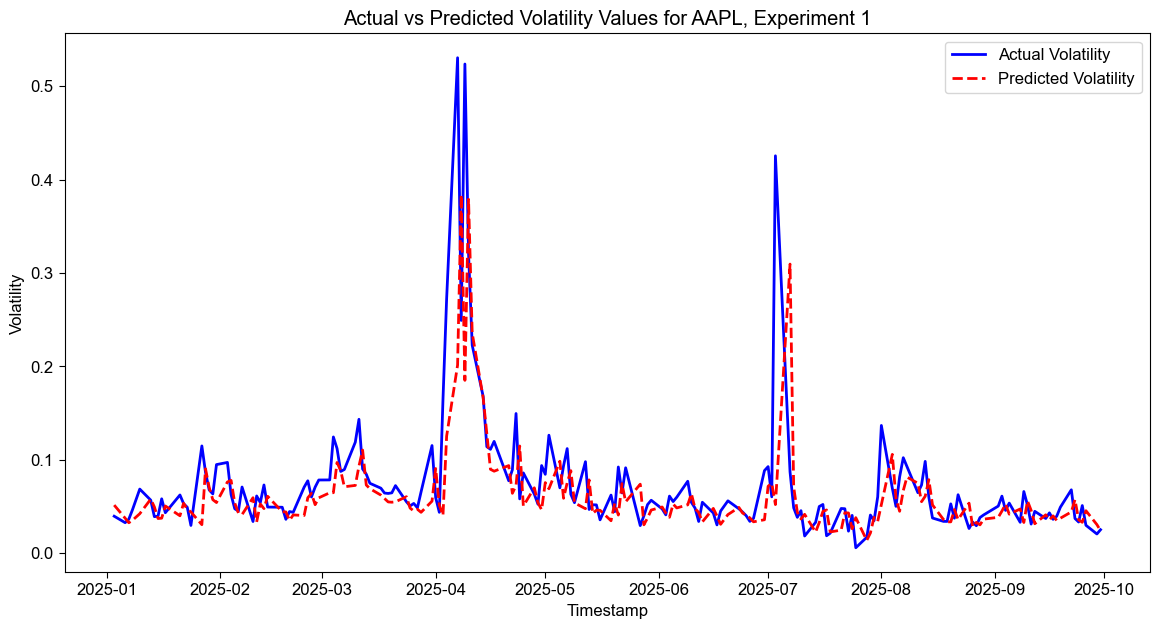

In [190]:
test_model_performance(grid_search, test_X, test_y, train_y, "AAPL", 1)

#### Experiment 2 AAPL

Experiment 2 includes the volatility from the previous day, as well as the lagged moving averages of returns, dollar volume, and volatility over 1, 5, 22, and 44 days of the previous day. The target is the volatility of today. The model now as 13 features.

In [191]:
experiment2 = reframed.drop(["var14(t-1)", "var15(t-1)"], axis=1)
train_X, train_y, test_X, test_y = get_train_test(experiment2)

(1214, 1, 13) (1214,) (185, 1, 13) (185,)


In [192]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result_exp2 = grid_search.fit(train_X, train_y)

Total model fits to perform: 180


The best features to use for experiment 2 with the AAPL stock are a batch size of 64, 25 epochs, a model rate of 0.01, and 64 model units. 

In [193]:
print_best_configuration(grid_result_exp2)


--- Best Configuration Found ---
Best RMSE (Score): 0.0386
Best Parameters: {'batch_size': 64, 'epochs': 25, 'model__learning_rate': 0.01, 'model__units': 64}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
19        -0.038573                  64                       0.010   
22        -0.038576                  64                       0.001   
21        -0.038684                  32                       0.001   
30        -0.038719                  32                       0.001   
32        -0.038784                 128                       0.001   

    param_batch_size  param_epochs  
19                64            25  
22                64            25  
21                64            25  
30                64            50  
32                64            50  


We then passed through the testing data through finetuned model. This outputs a root mean squared error of 0.0547, an AIC of -7020.78, and a BIC of -6934.05.

Root Mean Squared Error: 0.0547
AIC:  -7020.775723581048
BIC:  -6934.047232063517


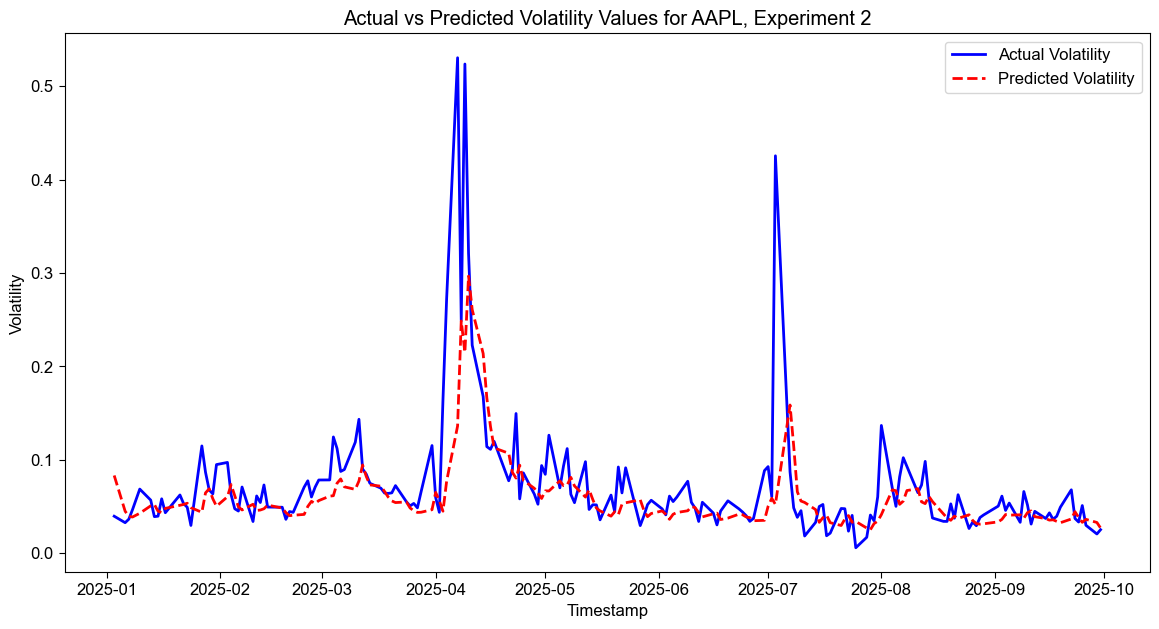

In [194]:
test_model_performance(grid_search, test_X, test_y, train_y, "AAPL", 2)

#### Experiment 3 AAPL

Experiment 3 contains the volatility of the previous day, the lagged moving averages, important calendar dates from the stock market, and quarterly earnings released dates. We describe how these last two features are encoded earlier in the notebook. The volatility of today is the target, and the model has a total of 15 features.

In [195]:
experiment3 = reframed
train_X, train_y, test_X, test_y = get_train_test(experiment3)

(1214, 1, 15) (1214,) (185, 1, 15) (185,)


In [196]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result_exp3 = grid_search.fit(train_X, train_y)

Total model fits to perform: 180


The best hyperparameters for experiment 3 AAPL are a batch size of 32, 50 epochs, a learning rate of 0.001, and 64 model units.

In [197]:
print_best_configuration(grid_result_exp3)


--- Best Configuration Found ---
Best RMSE (Score): 0.0380
Best Parameters: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.001, 'model__units': 64}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
13        -0.037952                  64                       0.001   
18        -0.038630                  32                       0.010   
22        -0.039022                  64                       0.001   
0         -0.039035                  32                       0.010   
30        -0.039406                  32                       0.001   

    param_batch_size  param_epochs  
13                32            50  
18                64            25  
22                64            25  
0                 32            25  
30                64            50  


We passed the testing data through the finetuned model and it outputs a rmse of 0.0538, an AIC of -7061.86, and a BIC of -6975.13

Root Mean Squared Error: 0.0538
AIC:  -7061.858412579006
BIC:  -6975.129921061475


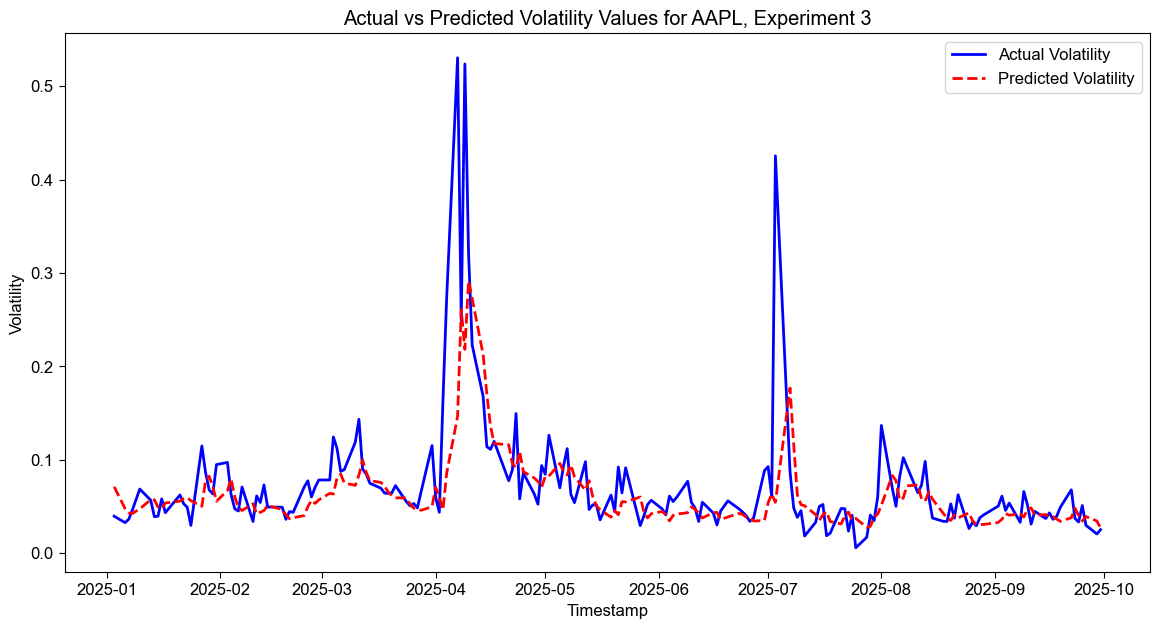

In [198]:
test_model_performance(grid_search, test_X, test_y, train_y, "AAPL", 3)

Experiment 3 performes best for AAPL according to all three metrics, RMSE, AIC, and BIC.

| AAPL | RMSE | AIC | BIC |
|--------|---|---|---|
| Experiment 1  | 0.0554 | -6990.34 | -6903.61 |
| Experiment 2    | 0.0547 | -7020.78 | -6934.05 |
| Experiment 3    | 0.0538 | -7061.86 | -6975.13 |

Therefore the best LSTM model for AAPL stock has 15 features (yesterday's volatility, lagged moving averages, important calendar dates, and quarterly earnings release dates), a batch size of 32, 50 epochs, a learning rate of 0.001, and 64 model units.

### LLY

Same as with AAPL stock we choose which features to include by performing the 3 experiments (each with a different number of features). We tune the hyperparameters of each experiment and compare the performance of the models with the testing data to find the best model for that particular stock

#### Experiment 1 LLY

In [199]:
LLY_stock = LLY_stock.drop(["Stock"], axis=1).set_index("time_stamp")
values = LLY_stock.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[list(range(16,30))], axis=1, inplace=True)

In [200]:
experiment1 = reframed[["var1(t-1)", "var1(t)"]]
train_X, train_y, test_X, test_y = get_train_test(experiment1)

(1214, 1, 1) (1214,) (185, 1, 1) (185,)


In [201]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result_exp1 = grid_search.fit(train_X, train_y)

Total model fits to perform: 180


The grid search says that the best parameters for LLY experiment 1 are a batch size of 32, 50 epochs, a learning rate of 0.001, and 128 model units.

In [202]:
print_best_configuration(grid_result_exp1)


--- Best Configuration Found ---
Best RMSE (Score): 0.0742
Best Parameters: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.0001, 'model__units': 128}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
17        -0.074156                 128                      0.0001   
21        -0.074359                  32                      0.0010   
35        -0.074672                 128                      0.0001   
3         -0.074719                  32                      0.0010   
15        -0.074750                  32                      0.0001   

    param_batch_size  param_epochs  
17                32            50  
21                64            25  
35                64            50  
3                 32            25  
15                32            50  


We pass this the testing data through this tuned model and its evaluation metrics are: rmse 0.0807, AIC -6078.47, and BIC -5991.75

Root Mean Squared Error: 0.0807
AIC:  -6078.474974179923
BIC:  -5991.746482662393


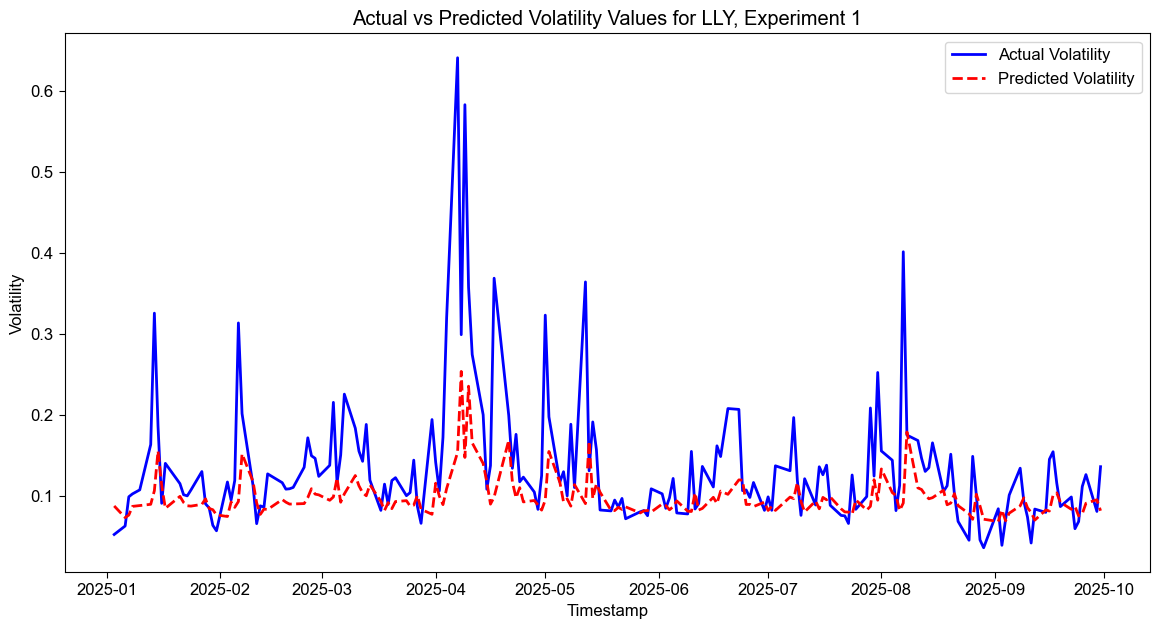

In [203]:
test_model_performance(grid_search, test_X, test_y, train_y, "LLY", 1)

#### Experiment 2 LLY

In [204]:
experiment2 = reframed.drop(["var14(t-1)", "var15(t-1)"], axis=1)
train_X, train_y, test_X, test_y = get_train_test(experiment2)

(1214, 1, 13) (1214,) (185, 1, 13) (185,)


In [205]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result_exp2 = grid_search.fit(train_X, train_y)

Total model fits to perform: 180


The best hyperparameters to use for experiment 2 LLY are a batch size of 64, 25 epochs, a learning rate of 0.001, and 64 model units.

In [206]:
print_best_configuration(grid_result_exp2)


--- Best Configuration Found ---
Best RMSE (Score): 0.0741
Best Parameters: {'batch_size': 64, 'epochs': 25, 'model__learning_rate': 0.001, 'model__units': 64}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
22        -0.074127                  64                      0.0010   
16        -0.074489                  64                      0.0001   
13        -0.074541                  64                      0.0010   
15        -0.074546                  32                      0.0001   
30        -0.074764                  32                      0.0010   

    param_batch_size  param_epochs  
22                64            25  
16                32            50  
13                32            50  
15                32            50  
30                64            50  


The performance metrics for LLY experiment 2 are rmse of 0.0691, AIC of -6455.49, and BIC of -6368.76

Root Mean Squared Error: 0.0691
AIC:  -6455.486736442182
BIC:  -6368.758244924651


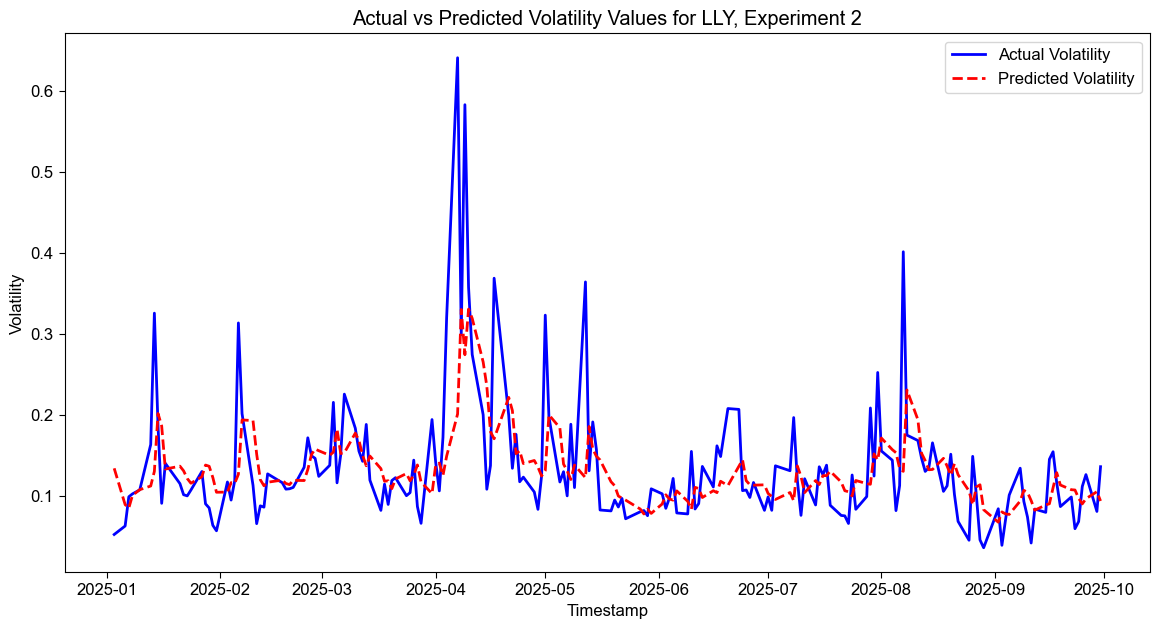

In [207]:
test_model_performance(grid_search, test_X, test_y, train_y, "LLY", 2)

#### Experiment 3 LLY

In [208]:
experiment3 = reframed
train_X, train_y, test_X, test_y = get_train_test(experiment3)

(1214, 1, 15) (1214,) (185, 1, 15) (185,)


In [209]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result_exp3 = grid_search.fit(train_X, train_y)

Total model fits to perform: 180


The best hyperparameters for experiment 3 LLY are a batch size of 64, 25 epochs, a learning rate of 0.001, and 32 model units.

In [210]:
print_best_configuration(grid_result_exp3)


--- Best Configuration Found ---
Best RMSE (Score): 0.0745
Best Parameters: {'batch_size': 64, 'epochs': 25, 'model__learning_rate': 0.001, 'model__units': 32}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
21        -0.074469                  32                      0.0010   
12        -0.074515                  32                      0.0010   
22        -0.074536                  64                      0.0010   
3         -0.074562                  32                      0.0010   
17        -0.074654                 128                      0.0001   

    param_batch_size  param_epochs  
21                64            25  
12                32            50  
22                64            25  
3                 32            25  
17                32            50  


The performance metrics for testing LLY experiment 3 are rmse of 0.0711, AIC of -6386.44, and BIC of -6299.71.

Root Mean Squared Error: 0.0711
AIC:  -6386.436123458867
BIC:  -6299.707631941336


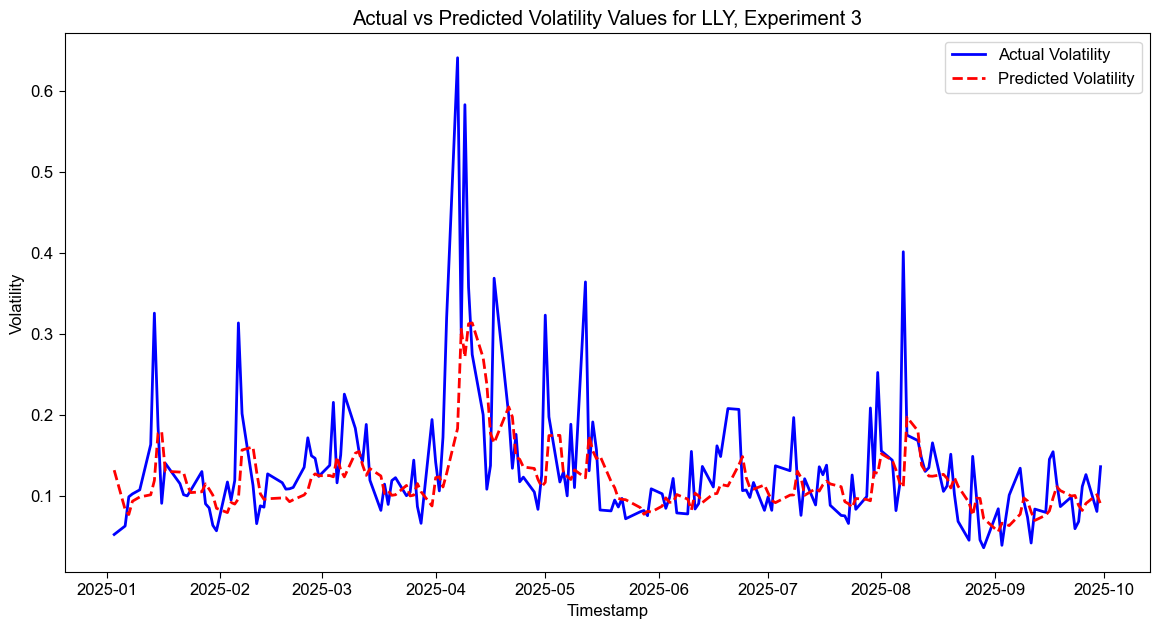

In [211]:
test_model_performance(grid_search, test_X, test_y, train_y, "LLY", 3)

Experiment 2 performs better than the other experiments for LLY stock.

| AAPL | RMSE | AIC | BIC |
|--------|---|---|---|
| Experiment 1  | 0.0807 | -6078.47 | -5991.75 |
| Experiment 2    | 0.0691 | -6455.49 | -6368.76 |
| Experiment 3    | 0.0711 | -6386.44 | -6299.71|

Therefore the best LSTM model for LLY stock has 13 features (yesterday's volatility and lagged moving averages), a batch size of 64, 25 epochs, a learning rate of 0.001, and 64 model units.

### NEE

In [212]:
NEE_stock = NEE_stock.drop(["Stock"], axis=1).set_index("time_stamp")
values = NEE_stock.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[list(range(16,30))], axis=1, inplace=True)

#### NEE Experiment 1

In [213]:
experiment1 = reframed[["var1(t-1)", "var1(t)"]]
train_X, train_y, test_X, test_y = get_train_test(experiment1)

(1214, 1, 1) (1214,) (185, 1, 1) (185,)


In [214]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result_exp1 = grid_search.fit(train_X, train_y)

Total model fits to perform: 180


The best hyperparameters for NEE experiment 1 are a batch size of 32, 50 epochs, a learning rate of 0.001, and 128 model units.

In [215]:
print_best_configuration(grid_result_exp1)


--- Best Configuration Found ---
Best RMSE (Score): 0.0327
Best Parameters: {'batch_size': 32, 'epochs': 50, 'model__learning_rate': 0.001, 'model__units': 128}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
14        -0.032663                 128                       0.001   
18        -0.032714                  32                       0.010   
29        -0.032977                 128                       0.010   
13        -0.033074                  64                       0.001   
27        -0.033082                  32                       0.010   

    param_batch_size  param_epochs  
14                32            50  
18                64            25  
29                64            50  
13                32            50  
27                64            50  


The performance metrics for testing optimized NEE experiment 1 model are a rmse of 0.0717, AIC of -6365.56, and BIC of -6278.83.

Root Mean Squared Error: 0.0717
AIC:  -6365.555133059306
BIC:  -6278.826641541776


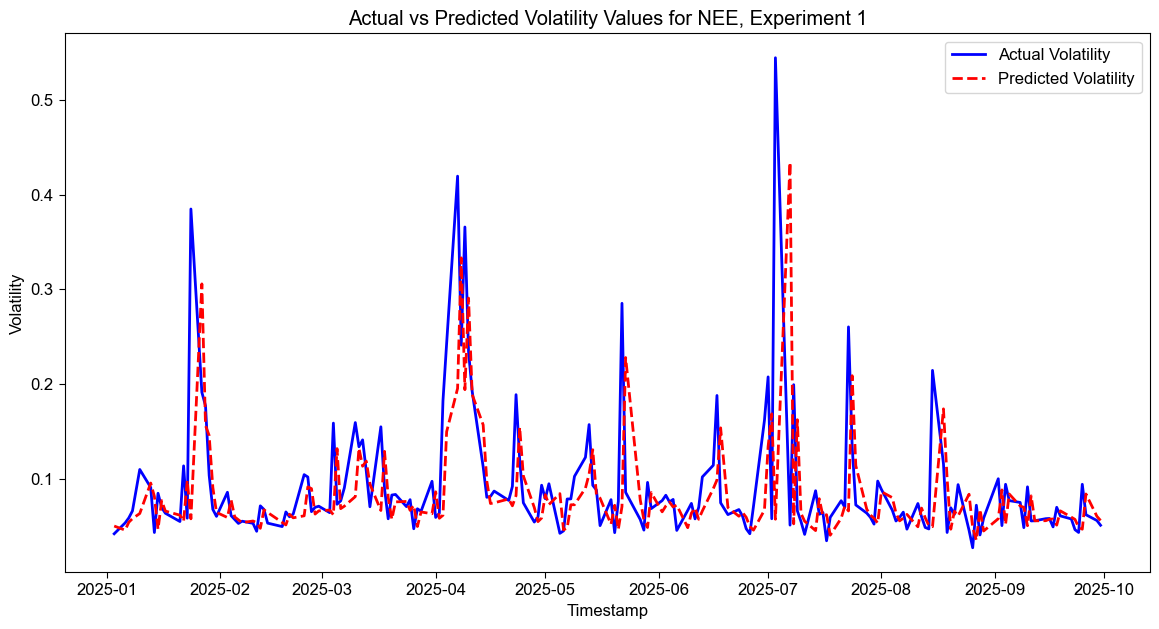

In [216]:
test_model_performance(grid_search, test_X, test_y, train_y, "NEE", 1)

### NEE Experiment 2

In [217]:
experiment2 = reframed.drop(["var14(t-1)", "var15(t-1)"], axis=1)
train_X, train_y, test_X, test_y = get_train_test(experiment2)

(1214, 1, 13) (1214,) (185, 1, 13) (185,)


In [218]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result_exp2 = grid_search.fit(train_X, train_y)

Total model fits to perform: 180


The best hyperparameters for NEE experiment 2 are a batch size of 64, 50 epochs, a learning rate of 0.01, and 32 model units.

In [219]:
print_best_configuration(grid_result_exp2)


--- Best Configuration Found ---
Best RMSE (Score): 0.0330
Best Parameters: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.01, 'model__units': 32}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
27        -0.033044                  32                       0.010   
13        -0.033293                  64                       0.001   
11        -0.033491                 128                       0.010   
12        -0.033499                  32                       0.001   
28        -0.033921                  64                       0.010   

    param_batch_size  param_epochs  
27                64            50  
13                32            50  
11                32            50  
12                32            50  
28                64            50  


When testing the optimized model for Experiment 2 NEE, the performance metrics are a rmse of 0.0640, AIC of -6639.68, and BIC of -6552.95.

Root Mean Squared Error: 0.0640
AIC:  -6639.675406404815
BIC:  -6552.946914887284


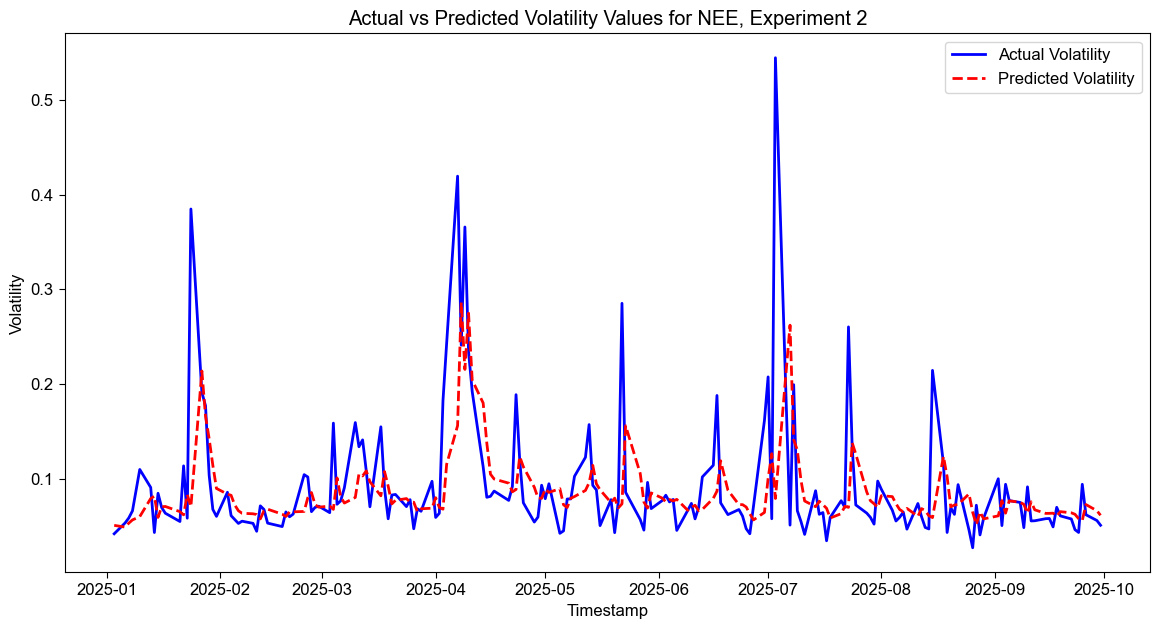

In [220]:
test_model_performance(grid_search, test_X, test_y, train_y, "NEE", 2)

#### NEE Experiment 3

In [221]:
experiment3 = reframed
train_X, train_y, test_X, test_y = get_train_test(experiment3)

(1214, 1, 15) (1214,) (185, 1, 15) (185,)


In [222]:
print(f"Total model fits to perform: {len(param_grid["model__units"]) * len(param_grid['model__learning_rate']) * len(param_grid['batch_size']) * len(param_grid['epochs']) * n_splits}")
grid_result_exp3 = grid_search.fit(train_X, train_y)

Total model fits to perform: 180


The best hyperparameters for experiment 3 NEE are a batch size of 64, 50 epochs, a learning rate of 0.001, and 64 model units.

In [223]:
print_best_configuration(grid_result_exp3)


--- Best Configuration Found ---
Best RMSE (Score): 0.0339
Best Parameters: {'batch_size': 64, 'epochs': 50, 'model__learning_rate': 0.001, 'model__units': 64}

Top 5 Parameter Combinations:
    mean_test_score  param_model__units  param_model__learning_rate  \
31        -0.033935                  64                       0.001   
14        -0.034130                 128                       0.001   
30        -0.034271                  32                       0.001   
13        -0.034334                  64                       0.001   
28        -0.034344                  64                       0.010   

    param_batch_size  param_epochs  
31                64            50  
14                32            50  
30                64            50  
13                32            50  
28                64            50  


When testing the optimized experiment 3 NEE model, the performance metrics are a rmse of 0.0678, AIC of -6500.22, and BIC of -6413.49.

Root Mean Squared Error: 0.0678
AIC:  -6500.220587480227
BIC:  -6413.492095962696


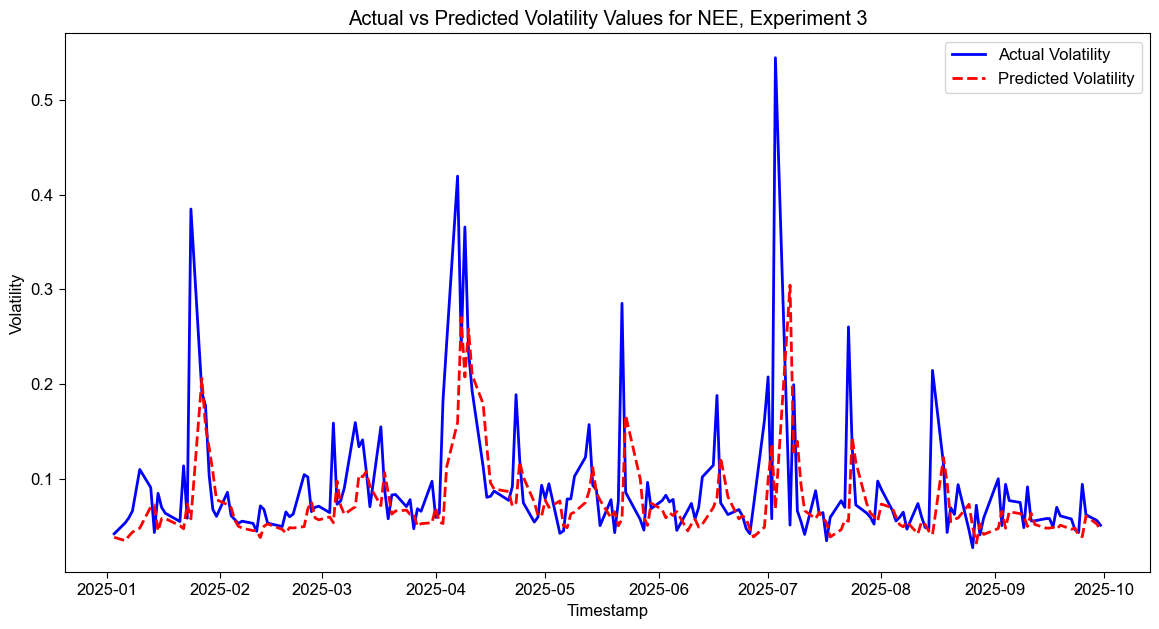

In [224]:
test_model_performance(grid_search, test_X, test_y, train_y, "NEE", 3)

Experiment 2 performs better than the other experiments for NEE stock.

| AAPL | RMSE | AIC | BIC |
|--------|---|---|---|
| Experiment 1  | 0.0712 | -6365.56 | -6278.83|
| Experiment 2    | 0.0640 | -6639.68 | -6662.95 |
| Experiment 3    | 0.0678 | -6500.22 | -6413.49|

Therefore the best LSTM model for NEE stock has 13 features (yesterday's volatility and lagged moving averages), a batch size of 64, 50 epochs, a learning rate of 0.01, and 32 model units.

Our data and modelling workflow can be thought of as a Machine Learning Morphism, a mapping from the raw market data to the volatility forecasts using data processing and modelling to learn a prediction function. The first phase of our MLM pipeline was downloading and cleaning our data, as described in the previous step. The processed data forms the input for our morphism. The next phase of our MLM is model training which has three contributing sub-components, each corresponding to a modelling technique. The EWMA sub-component captures the deterministic relationships in the data. The ARIMA sub-component adds mean-related dynamics and lag correlation to the mapping. Finally, the RNN sub-component contributes historic, temporal context to our learning problem. Our MLM is constrained by the necessity of meaningful prediction values. Our predictions need to be stable and financially valid. For example, a negative stock price and, thus, a negative volatility forecast, is meaningless since financial markets do not support negative pricing. Also, our MLM can only use past data to make predictions, which, on a theory level, behaves as a constraint. Further, each sub-component has its own mathematical constraints, like how the weights in an EWMA model must sum to equal one. Through this perspective, our project workflow is an MLM.

Speficially diving into one of the models, our neural network that we plan to build, can be mapped as a Machine Learning Morphism. Its input space consists of volatility, lagged moving averages, earnings history, quarterly earnings release date, and calendar dates that have large effects on stock prices. The processing consists of the data processing of the minutely returns as mentioned above, as well as encoding the calendar dates into categories and how far a stock is from its quarterly earning release. Its output space will be all real numbers greater than or equal to 0, the predicted volatility for the next day. For the parametric morphism (Fp), we will be using a Recurrent Neural Network. It is a supervised learning paradigm since we have historical volatility that will be used as labels. The neural network is being used to perform regression and we will use the mean squared error as the loss function. The predicted volatility can not be a negative number, so there will be a constraint in the model that the output has to be greater than or equal to zero.


# Results and Insights

### Model Comparison

In [105]:
# Baseline Models
def compare_models(ticker_name, ewma_res, arima_res, garch_res, original_data):
    """
    Compares EWMA, ARIMA, and GARCH models.
    """
    metrics = {}
    
    # EWMA
    ewma_rmse = np.sqrt(np.mean(ewma_res.resid**2))
    metrics['EWMA'] = {'AIC': np.nan, 'BIC': np.nan, 'RMSE': ewma_rmse}

    # ARIMA

    arima_rmse = np.sqrt(np.mean(arima_res.resid()**2))
    metrics['ARIMA'] = {'AIC': arima_res.aic(), 'BIC': arima_res.bic(), 'RMSE': arima_rmse}

    # GARCH
    garch_rmse = np.sqrt(mean_squared_error(original_data, garch_res.conditional_volatility))
    metrics['GARCH'] = {'AIC': garch_res.aic, 'BIC': garch_res.bic, 'RMSE': garch_rmse}
    
    # Create DataFrame
    df_metrics = pd.DataFrame(metrics).T
    print(f"--- Model Comparison for {ticker_name} ---")
    display(df_metrics)
    return df_metrics

# Run the comparison
aapl_comparison = compare_models("AAPL", aapl_ewma, aapl_arima, aapl_garch, aapl_vol['volatility'])
nee_comparison = compare_models("NEE", nee_ewma, nee_arima, nee_garch, nee_vol['volatility'])
lly_comparison = compare_models("LLY", lly_ewma, lly_arima, lly_garch, lly_vol['volatility'])

--- Model Comparison for AAPL ---


,AIC,BIC,RMSE
EWMA,NaN,NaN,0.042498
ARIMA,-2606.102279,-2596.799136,0.045038
GARCH,-1260.083671,-1246.125082,0.045496


--- Model Comparison for NEE ---


,AIC,BIC,RMSE
EWMA,NaN,NaN,0.044844
ARIMA,-2525.690828,-2507.231926,0.044283
GARCH,-1261.286523,-1233.598169,0.045003


--- Model Comparison for LLY ---


,AIC,BIC,RMSE
EWMA,NaN,NaN,0.048349
ARIMA,-2485.155743,-2466.643577,0.046520
GARCH,-1205.989533,-1173.593243,0.047553


**MODEL COMPARISON**

Since our project uses time series data, it was not feasible to implement nested cross-validation for model comparison. Instead, we used a collection of performance metrics: AIC, BIC, and RMSE. AIC (Akaike Information Criterion) shows the goodness of fit of a model and maximizes the model's predictive ability. A lower AIC score is better. BIC (Bayesian Information Criterion) focuses on consistency, penalizing models with unnecessarily high numbers of parameters. BIC scores emphasize a model's fitto  the underlying data structures. Like AIC, the lower BIC score is better. RMSE (Root Mean Squared Error) measures forecast accuracy by assessing the Euclidean distance between the predicted test values and the true test values. Due to this, RMSE penalizes large misses (outliers) more heavily. As with AIC and BIC, the best performing model (with respect to RMSE) will have the minimal RMSE score.

**BASELINE MODELS**

We found that the results of the three performance metrics were consistent in almost all instances. In fact, there was only one case that did not follow this trend. Using AIC, BIC, and RMSE, we can conclude that the ARIMA model works best for NEE and LLY volatility predictions. The AIC and BIC scores suggest that the same is also true for the AAPL volatility prediction. On the other hand, the RMSE metric suggests that EWMA performs best for AAPL volatility predictions. This discrepancy is likely because ARIMA models generalize by forecasting the average value. Thus, shocks that are captured by EWMA will not have the same model reaction as an ARIMA model. The result is that the magnitude of misses at shocks will have a heavy weight on the RMSE for an ARIMA model, even if the ARIMA model generalizes better. The difference in results between different performance metrics demonstrates why it is important to evaluate the model in the context of the performance method(s) you are using and not assume that all performance statistics will agree. 

Based on these results, we chose the set of ARIMA models as our best baseline model for each stock.

**ARIMA v LSTM**

We found that the results of AIC and BIC consistent in all instances, but RMSE always differed. For AAPL, AIC and BIC both suggested that the LSTM with 15 features (Experiment 3) performed best. Meanwhile, RMSE favored ARIMA. For LLY and NEE, AIC and BIC were best for the LSTM with 13 features (Experiment 2). Similarly, RMSE scored better for ARIMA. The split between model performance leaves an interesting decision to make and perhaps indicates that both ARIMA and LSTM models should be taken into consideration for our application. The ARIMA models always have better RMSE, which indicates higher forecast accuracy. Thus, for predicting the value of volatility for the next day, the set of ARIMA models should be used. Simultaneously, the lower AIC and BIC of the LSTM models imply that the expected risk measurement is more accurate. Therefore, using these models in parallel could be helpful, as the LSTM can provide the amount of inherent risk from investment, while the ARIMA model can add the actual amount of volatility.

Something else interesting to note is that the LSTM models with additional features (Experimements 2 and 3) consistently perform better across all metrics than the Experienment 1 LSTM. This result is inuitive, as the additional features provide more relationships within the data. Specifically, the moving average values make underlying trends in the data more apparent. The added dates in Experiment 3 provide information of specific days when we can expect more or less volatility accordingly.


# Conclusion

In this project, we sought to find an innovative approach to forecasting volatility. We zeroed in on three stocks, all in different sectors that we are interested in, Apple, Eli Lilly, and NextEra. We looked at predicting the volatility of the next day as we wanted this to be used as a tool for customers to decide what immediate action to take regarding a particular stock. First we researched forecasting volatiliity to get a better understanding common practices. We wanted to learn what models are commonly used to predict volatility and compare our more robust model to their performances. Through this research we decided to use EWMA, ARIMA, and GARCH as the baseline models. These models are fairly effective which may be due to the fact that volatility is highly autoregressive and the primary driver of next day volatility is past volatility.\
In general though, predicting volatility perfectly is difficult since volatility is by definition unpredictable. There are some known things that can cause a panic or change in behavior. Because of this, we decided to include the important calendar dates and quarterly earnings release schedule in the dataset for LSTM. Dispite this logic, the performance of the models shows that including the calendar dates and quarterly earnings release schedule does not always yield a better result. This may be due to the fact that these events are known and the markets will adjust before the event occurs. Looking towards the future, we are interested in testing a hybrid GARCH-LSTM model [3] to see how a combination of our techniques performs. Ultimately, while volatility is unpredictable and subject to random external shocks, models are able to forecaset effectively due to its highly autoregressive nature.

# References

[1] Alpha Vantage Inc., “Alpha Vantage API documentation.” [Online]. Available: https://www.alphavantage.co/documentation/. [Accessed: Dec. 12, 2025].\
[2] R. Goyenko, B. T. Kelly, T. J. Moskowitz, Y. Su, and C. Zhang, “Trading Volume Alpha,” SSRN, Apr. 23, 2024, revised Jun. 12, 2025. [Online]. Available: SSRN. [Accessed: Dec. 12, 2025].\
[3] H. Y. Kim and C. H. Won, "Forecasting the volatility of stock price index: A hybrid model integrating LSTM with multiple GARCH-type models," Expert Syst. Appl., vol. 103, pp. 25-37, Mar. 2018.